## Overview 


**Introduction**  
This notebook was developed in response to Kaggle's 2018 NCAA Men's Basketball Tournament ('March Madness") prediction contest. Contest participants were given extensive historical team and game data and asked to predict every possible match-up among 68 teams in the annual basketball tournament.  Rather than simply reward win/loss prediction accuracy, the contest factored in the probability a model gave to each prediction, using log-loss as its key metric.  As a result, the contest combined accuracy with predicted probabilities, harshly penalizing incorrect predictions made with high confidence. 

The winners of the last 4 March Madness competitions had final log-loss scores of:  

- 2017: 0.4386   
- 2016: 0.4813   
- 2015: 0.4389   
- 2014: 0.5295   

Details on the Kaggle competition are here:  https://www.kaggle.com/c/mens-machine-learning-competition-2018


**Data**  
Kaggle provided extensive historical data, with varying levels of detail across many different data files.  A significant amount of processing work was required to derive meaningful features and to join datasets together.  

Below, I loaded the key datasets for my approach (eight datasets), then conducted varying degrees of data processing at the file-specific level and more extensive processing later as the files were joined together and various data points evaluated in combination.

At a high level, I used the historic NCAA tournament's game results as my master file for modeling and predicting.  This file provided a summary of each match in NCAA tournaments going back to 1985.  I appended various other data points to this file, including season-long game statistics, conference affiliations and third-party rankings. As a result, each observation in the master file includes the result of a past tournament game along with extensive statistics about each team (and those team's prior opponents).

After preliminary modeling, it became clear that a series of statistics that measured the difference between Team 1's and Team 2's performance across different metrics provided significant predictive power.  In the end, my final feature set was a combination of these "difference" statistics along with the most predictive single-team statistics, identified through preliminary modeling. 

Third-party rankings proved especially powerful in terms of predicting outcomes, but the availability of ranking data over the years is inconsistent.  For this reason, I chose to limit my master dataset to the years after 2003. 

Additionally, after preliminary modeling, I collapsed over 30 conference affiliations for the combined teams down to the "Power 6" conferences and an "other" category (i.e., a total of seven groupings by conference).  This approach reduced the number of dimensions and appeared to reduce model over-fitting.  With a relatively small amount of historical data on tournament games, the models could have been "learning" specific game outcomes based on the granular conference affiliations, rather than generalizing from the historic data.

I used game and associated data from 2003 to 2016 to train various predictive models, with the 2017 results held out for validation purposes.  Additionally, I generated and used two versions of the data -- one with the raw data and another with scaled and one-hot-encoded data, to be used appropriately depending on model.

In the last stage of the contest, after the 2018 tournament's 68 teams were selected in early March, final data for the 2018 prediction contest was released.  Submissions for the contest were due before the first tournament game was played (ignoring the initial play-in round that eliminated the first four teams).

The data processing sections below now include the 2018 data up to the start of the 2018 tournament, so that features could be derived for the 2018 tournament match ups.  Again, however, the models were trained on data through 2017.  That data can be picked up in fully processed form in section 2.7.8 below.  The 2018 data (features, without outcomes) is used in the final 2018 prediction phase (section 5).

**Models and Results**
I trained and tested six models on the data.  The Neural Network model performed best, achieving a 0.4769 best log-loss score on the 2017 validation dataset. The Logistice Regression model was next, at 0.4842. I experimented with stacking and ensemblimg models, but they did not yield better performance than the standalone Neural Network or Logistic Regression model.  This was perhaps due to the limited number of historical tournament games -- and stacking requires further splitting of the training samples. 

Two submissions were allowed in the contest, and I submitted the Neural Network and Logistic Regression models. I will provide a 2018 update on my log-loss scores in early April 2018, once the tournament ends. 

Update: to come. 

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib as plt
%matplotlib inline

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

data_dir = 'C:/Users/Robert McKee/NCAA_tourney_competition/Data/Stage_2/'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Load the training data ##

### Tournament  Results 

This file will serve as our master dataset -- to which detailed team and game statistics will be appended.  Also, 
we will later append 2018 potential match-ups (this data was released separately in early March 2018 after the 68 tournament teams were announced). The 2018 data is appended in section 2.7.1.

In [3]:
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.tail(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2115,2017,152,1314,77,1332,76,N,0
2116,2017,154,1314,71,1211,65,N,0


### Season-Long Data 

Summary-level game data

In [4]:
df_seasons = pd.read_csv(data_dir + 'RegularSeasonCompactResults.csv')
df_seasons.tail(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
156087,2018,132,1246,77,1397,72,N,0
156088,2018,132,1335,68,1217,65,N,0


In [5]:
df_seasons.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT
count,156089.000000,156089.000000,156089.000000,156089.000000,156089.000000,156089.000000,156089.000000
mean,2002.676749,74.916106,1286.911044,76.756895,1282.612727,64.654095,0.046627
std,9.783024,33.468727,104.560253,12.109720,104.728288,11.368591,0.253754
min,1985.000000,0.000000,1101.000000,34.000000,1101.000000,20.000000,0.000000
25%,1994.000000,47.000000,1198.000000,68.000000,1191.000000,57.000000,0.000000
50%,2003.000000,77.000000,1284.000000,76.000000,1280.000000,64.000000,0.000000
75%,2011.000000,103.000000,1380.000000,84.000000,1375.000000,72.000000,0.000000
max,2018.000000,132.000000,1464.000000,186.000000,1464.000000,150.000000,6.000000


Detailed box scores for each game 

In [6]:
df_seasons_box = pd.read_csv(data_dir + 'RegularSeasonDetailedResults.csv')
df_seasons_box.head().T

,0,1,2,3,4
Season,2003,2003,2003,2003,2003
DayNum,10,10,11,11,11
WTeamID,1104,1272,1266,1296,1400
WScore,68,70,73,56,77
LTeamID,1328,1393,1437,1457,1208
LScore,62,63,61,50,71
WLoc,N,N,N,N,N
NumOT,0,0,0,0,0
WFGM,27,26,24,18,30
WFGA,58,62,58,38,61


In [7]:
def assign_loc(row) :
    """Assigns location to losing team, based on what is shown for winning team"""
    if row['WLoc']=='H' :
        return 'A'
    elif row['WLoc']=='A' :
        return 'H'
    else : 
        return 'N'
df_seasons_box['LLoc']=df_seasons_box.apply(assign_loc,axis=1)

Break down box scores into winners and losers datasets -- and then concatenate back into one 

In [ ]:
df_winners=df_seasons_box[['Season', 'DayNum','WTeamID', 'WScore','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WLoc']]
df_winners['Result']=1
df_winners.tail(2)

In [9]:
df_losers=df_seasons_box[['Season', 'DayNum','LTeamID', 'LScore','LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LLoc']]
df_losers['Result']=0
df_losers.tail(2)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Season,DayNum,LTeamID,LScore,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,LLoc,Result
82036,2018,132,1222,55,19,55,7,23,10,12,9,20,12,12,8,2,19,N,0
82037,2018,132,1348,57,20,52,8,23,9,17,11,26,12,14,3,4,16,N,0
82038,2018,132,1426,61,17,57,4,25,23,28,19,24,9,13,1,5,16,N,0
82039,2018,132,1397,72,23,62,10,27,16,20,18,16,14,10,4,3,21,N,0
82040,2018,132,1217,65,23,55,7,18,12,12,5,29,6,8,2,2,17,N,0


In [10]:
df_winners.columns=['Season', 'DayNum','TeamID', 'Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 
                    'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Loc', 'Result']
df_losers.columns=['Season', 'DayNum','TeamID', 'Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 
                    'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Loc', 'Result']

In [11]:
# Concat winners and losers and sort by season and team id; reindex
df_box_master=pd.concat([df_winners,df_losers], ignore_index=True)
df_box_master.shape

(164082, 19)

In [12]:
df_box_master.head(2)

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result
0,2003,10,1104,68,27,58,3,14,11,18,14,24,13,23,7,1,22,N,1
1,2003,10,1272,70,26,62,8,20,10,19,15,28,16,13,4,4,18,N,1


In [13]:
df_box_master = df_box_master.sort_values(["Season", "TeamID", 'DayNum']).reset_index(drop=True)

In [14]:
# df_box_master.to_pickle('df_box_master1_to2018.pkl')
# df_box_master=pd.read_pickle('df_box_master_to2018')

#### WInning Percentage by Season by Team

In [15]:
# Sum up wins for each team by season 
grouped = df_box_master.groupby(['Season', 'TeamID'])['Result'].aggregate({'Wins': np.sum}).reset_index()
grouped.head()

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Season,TeamID,Wins
0,2003,1102,12
1,2003,1103,13
2,2003,1104,17
3,2003,1105,7
4,2003,1106,13


In [16]:
# Merge the wins into the master file 
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')
df_box_master.head(3)

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result,Wins
0,2003,19,1102,47,16,40,6,21,9,16,3,17,8,17,2,0,21,A,0,12
1,2003,22,1102,72,26,46,15,28,5,7,5,22,19,9,6,8,13,H,1,12
2,2003,25,1102,57,16,36,7,20,18,22,3,24,10,10,5,3,20,A,1,12
3,2003,27,1102,47,15,35,10,19,7,12,1,8,13,12,5,0,20,A,0,12
4,2003,31,1102,65,23,40,18,33,1,7,5,14,20,7,7,5,16,H,1,12


In [17]:
# Count total games by season by team and add to master
grouped = df_box_master.groupby(['Season', 'TeamID'])['Result'].aggregate({'Games': 'count'}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')
df_box_master.head(3)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result,Wins,Games
0,2003,19,1102,47,16,40,6,21,9,16,3,17,8,17,2,0,21,A,0,12,28
1,2003,22,1102,72,26,46,15,28,5,7,5,22,19,9,6,8,13,H,1,12,28
2,2003,25,1102,57,16,36,7,20,18,22,3,24,10,10,5,3,20,A,1,12,28
3,2003,27,1102,47,15,35,10,19,7,12,1,8,13,12,5,0,20,A,0,12,28
4,2003,31,1102,65,23,40,18,33,1,7,5,14,20,7,7,5,16,H,1,12,28


In [18]:
# Calculate winning percentages 
grouped= df_box_master.groupby(['Season', 'TeamID']).apply(lambda x: x['Wins'] / x ['Games']).reset_index(name='WinPct')
grouped.head()

,Season,TeamID,level_2,WinPct
0,2003,1102,0,0.428571
1,2003,1102,1,0.428571
2,2003,1102,2,0.428571
3,2003,1102,3,0.428571
4,2003,1102,4,0.428571


In [19]:
# Append win pct to master box score stats 
df_box_master['WinPct']=grouped['WinPct']
df_box_master.head(2)

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result,Wins,Games,WinPct
0,2003,19,1102,47,16,40,6,21,9,16,3,17,8,17,2,0,21,A,0,12,28,0.428571
1,2003,22,1102,72,26,46,15,28,5,7,5,22,19,9,6,8,13,H,1,12,28,0.428571


#### Winning Pct by Away/Neutral sites 

Historically, home teams win about 2 out of 3 games played during the season.  As a result, away/neutral winning pct might provide some predictive value for the NCAA tournament, where games are played in sites considered neutral (though a local team close to the neutral site might enjoy some advantages of the "home" team).  

In [21]:
# Limit df to away/neutral sites 
df_away_neutral=df_box_master.copy()
df_away_neutral=df_away_neutral.loc[df_away_neutral.Loc!='H']
df_away_neutral.shape

(90352, 22)

In [22]:
# Count the wins for away/neutral sites 
grouped = df_away_neutral.groupby(['Season', 'TeamID'])['Result'].aggregate({'WinsAwayNeutral': np.sum}).reset_index()

# Merge the away/neutral wins into the away/neutral master file 
df_away_neutral=df_away_neutral.merge(grouped, on=['Season', 'TeamID'], how='left')
df_away_neutral.head(3)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result,Wins,Games,WinPct,WinsAwayNeutral
0,2003,19,1102,47,16,40,6,21,9,16,3,17,8,17,2,0,21,A,0,12,28,0.428571,3
1,2003,25,1102,57,16,36,7,20,18,22,3,24,10,10,5,3,20,A,1,12,28,0.428571,3
2,2003,27,1102,47,15,35,10,19,7,12,1,8,13,12,5,0,20,A,0,12,28,0.428571,3
3,2003,34,1102,70,24,42,12,24,10,17,5,12,20,10,9,1,13,A,1,12,28,0.428571,3
4,2003,48,1102,44,16,45,8,27,4,7,8,20,8,18,3,0,25,A,0,12,28,0.428571,3


In [23]:
# Count total away/neutral games by season by team and add to away/neutral df
grouped = df_away_neutral.groupby(['Season', 'TeamID'])['Result'].aggregate({'GamesAwayNeutral': 'count'}).reset_index()
df_away_neutral=df_away_neutral.merge(grouped, on=['Season', 'TeamID'], how='left')
df_away_neutral.head(3)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result,Wins,Games,WinPct,WinsAwayNeutral,GamesAwayNeutral
0,2003,19,1102,47,16,40,6,21,9,16,3,17,8,17,2,0,21,A,0,12,28,0.428571,3,15
1,2003,25,1102,57,16,36,7,20,18,22,3,24,10,10,5,3,20,A,1,12,28,0.428571,3,15
2,2003,27,1102,47,15,35,10,19,7,12,1,8,13,12,5,0,20,A,0,12,28,0.428571,3,15
3,2003,34,1102,70,24,42,12,24,10,17,5,12,20,10,9,1,13,A,1,12,28,0.428571,3,15
4,2003,48,1102,44,16,45,8,27,4,7,8,20,8,18,3,0,25,A,0,12,28,0.428571,3,15


In [24]:
# Calculate away/neutral winning percentages 
grouped= df_away_neutral.groupby(['Season', 'TeamID']).apply(lambda x: x['WinsAwayNeutral'] / x ['GamesAwayNeutral']).reset_index(name='WinPctAwayNeut')
grouped.head(30)

,Season,TeamID,level_2,WinPctAwayNeut
0,2003,1102,0,0.200000
1,2003,1102,1,0.200000
2,2003,1102,2,0.200000
3,2003,1102,3,0.200000
4,2003,1102,4,0.200000
5,2003,1102,5,0.200000
6,2003,1102,6,0.200000
7,2003,1102,7,0.200000
8,2003,1102,8,0.200000
9,2003,1102,9,0.200000


In [25]:
# Drop duplicate rows 
grouped.drop(columns='level_2', inplace=True)
grouped.drop_duplicates(inplace=True)
grouped.head()

,Season,TeamID,WinPctAwayNeut
0,2003,1102,0.200000
15,2003,1103,0.307692
28,2003,1104,0.307692
41,2003,1105,0.142857
55,2003,1106,0.312500


In [26]:
# Add away/neutral winning pct to master df
df_box_master=df_box_master.merge(grouped, how='left', on=['Season', 'TeamID'])
df_box_master.head()

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result,Wins,Games,WinPct,WinPctAwayNeut
0,2003,19,1102,47,16,40,6,21,9,16,3,17,8,17,2,0,21,A,0,12,28,0.428571,0.2
1,2003,22,1102,72,26,46,15,28,5,7,5,22,19,9,6,8,13,H,1,12,28,0.428571,0.2
2,2003,25,1102,57,16,36,7,20,18,22,3,24,10,10,5,3,20,A,1,12,28,0.428571,0.2
3,2003,27,1102,47,15,35,10,19,7,12,1,8,13,12,5,0,20,A,0,12,28,0.428571,0.2
4,2003,31,1102,65,23,40,18,33,1,7,5,14,20,7,7,5,16,H,1,12,28,0.428571,0.2


In [28]:
# df_box_master.to_pickle('df_box_master2_to2018.pkl')
# df_box_master=pd.read_pickle('df_box_master_to2018')

#### Other Game Stats by Season 

Follow the same approach as above to derive a variety of season-long stats 

In [29]:
# Series of aggregations for subsequent use in deriving stats; each merged into the master box scores file  

grouped = df_box_master.groupby(['Season', 'TeamID'])['Score'].aggregate({'TotPts': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['FGM'].aggregate({'TotFGM': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['FGA'].aggregate({'TotFGA': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['FGM3'].aggregate({'TotFGM3': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['FGA3'].aggregate({'TotFGA3': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['FTM'].aggregate({'TotFTM': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['FTA'].aggregate({'TotFTA': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['OR'].aggregate({'TotOR': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['DR'].aggregate({'TotDR': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['Ast'].aggregate({'TotAst': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['TO'].aggregate({'TotTO': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['Stl'].aggregate({'TotStl': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['Blk'].aggregate({'TotBlk': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_box_master.groupby(['Season', 'TeamID'])['PF'].aggregate({'TotPF': np.sum}).reset_index()
df_box_master=df_box_master.merge(grouped, on=['Season', 'TeamID'], how='left')


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py

In [30]:
# df_box_master.to_pickle('df_box_master3_to2018.pkl')
# df_box_master=pd.read_pickle('df_box_master_to2018')

In [32]:
# Use the aggregations to derive new summary stats
def fg_pct(row) :
    return row['TotFGM'] / row ['TotFGA']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(fg_pct).reset_index(name='TotFGPct')
df_box_master['TotFGPct']=grouped['TotFGPct']

def fg_pct_3(row) :
    return row['TotFGM3'] / row ['TotFGA3']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(fg_pct_3).reset_index(name='TotFGPct3')
df_box_master['TotFGPct3']=grouped['TotFGPct3']

def ft_pct(row) :
    return row['TotFTM'] / row ['TotFTA']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(ft_pct).reset_index(name='TotFTPct')
df_box_master['TotFTPct']=grouped['TotFTPct']

def avg_oreb(row) :
    return row['TotOR'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_oreb).reset_index(name='TotOrPct')
df_box_master['TotOrPct']=grouped['TotOrPct']

def avg_dreb(row) :
    return row['TotDR'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_dreb).reset_index(name='TotDrPct')
df_box_master['TotDrPct']=grouped['TotDrPct']

def avg_asst(row) :
    return row['TotAst'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_asst).reset_index(name='TotAsstPct')
df_box_master['TotAsstPct']=grouped['TotAsstPct']

def avg_to(row) :
    return row['TotTO'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_to).reset_index(name='TotTOPct')
df_box_master['TotTOPct']=grouped['TotTOPct']

def avg_stl(row) :
    return row['TotStl'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_stl).reset_index(name='TotStlPct')
df_box_master['TotStlPct']=grouped['TotStlPct']

def avg_blk(row) :
    return row['TotBlk'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_blk).reset_index(name='TotBlkPct')
df_box_master['TotBlkPct']=grouped['TotBlkPct']

def avg_pf(row) :
    return row['TotPF'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_pf).reset_index(name='TotPFPct')
df_box_master['TotPFPct']=grouped['TotPFPct']

def avg_pts(row) :
    return row['TotPts'] / row ['Games']
grouped = df_box_master.groupby(['Season', 'TeamID']).apply(avg_pts).reset_index(name='TotPtsAvg')
df_box_master['TotPtsAvg']=grouped['TotPtsAvg']

df_box_master.head(3)


,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Loc,Result,Wins,Games,WinPct,WinPctAwayNeut,TotPts,TotFGM,TotFGA,TotFGM3,TotFGA3,TotFTM,TotFTA,TotOR,TotDR,TotAst,TotTO,TotStl,TotBlk,TotPF,TotFGPct,TotFGPct3,TotFTPct,TotOrPct,TotDrPct,TotAsstPct,TotTOPct,TotStlPct,TotBlkPct,TotPFPct,TotPtsAvg
0,2003,19,1102,47,16,40,6,21,9,16,3,17,8,17,2,0,21,A,0,12,28,0.428571,0.2,1603,536,1114,219,583,312,479,117,471,364,320,167,50,525,0.481149,0.375643,0.651357,4.178571,16.821429,13.0,11.428571,5.964286,1.785714,18.75,57.25
1,2003,22,1102,72,26,46,15,28,5,7,5,22,19,9,6,8,13,H,1,12,28,0.428571,0.2,1603,536,1114,219,583,312,479,117,471,364,320,167,50,525,0.481149,0.375643,0.651357,4.178571,16.821429,13.0,11.428571,5.964286,1.785714,18.75,57.25
2,2003,25,1102,57,16,36,7,20,18,22,3,24,10,10,5,3,20,A,1,12,28,0.428571,0.2,1603,536,1114,219,583,312,479,117,471,364,320,167,50,525,0.481149,0.375643,0.651357,4.178571,16.821429,13.0,11.428571,5.964286,1.785714,18.75,57.25


In [33]:
# df_box_master.to_pickle('df_box_master4_to2018.pkl')
# df_box_master=pd.read_pickle('df_box_master_to2018')

In [34]:
df_box_summary_master=df_box_master.copy()

In [36]:
# Reduce columns to just the summary stats (not the raw numbers)
df_box_summary_master = df_box_summary_master[[
    'Season', 'TeamID', 'WinPct', 'WinPctAwayNeut','TotPtsAvg', 'TotFGPct', 'TotFGPct3',
    'TotFTPct', 'TotOrPct', 'TotDrPct', 'TotAsstPct', 'TotTOPct', 'TotStlPct',
    'TotBlkPct', 'TotPFPct'
]]
df_box_summary_master.shape

(164082, 15)

In [37]:
# Condense rows to just one observation per year per team -- rather than separate ones for each game
df_box_summary_master.drop_duplicates(inplace=True)
df_box_summary_master.reset_index(drop=True, inplace=True)
df_box_summary_master.shape

(5481, 15)

In [39]:
# df_box_summary_master.to_pickle('df_box_summary_master1_to2018.pkl')
# df_box_summary_master=pd.read_pickle('df_box_summary_master1_to2018.pkl')

In [40]:
df_box_summary_master.head(20)

,Season,TeamID,WinPct,WinPctAwayNeut,TotPtsAvg,TotFGPct,TotFGPct3,TotFTPct,TotOrPct,TotDrPct,TotAsstPct,TotTOPct,TotStlPct,TotBlkPct,TotPFPct
0,2003,1102,0.428571,0.200000,57.250000,0.481149,0.375643,0.651357,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000
1,2003,1103,0.481481,0.307692,78.777778,0.486074,0.338710,0.736390,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852
2,2003,1104,0.607143,0.307692,69.285714,0.420362,0.320144,0.709898,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714
3,2003,1105,0.269231,0.142857,71.769231,0.395755,0.364815,0.705986,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769
4,2003,1106,0.464286,0.312500,63.607143,0.423773,0.346154,0.646421,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571
5,2003,1107,0.250000,0.142857,65.928571,0.418272,0.357488,0.733509,8.250000,20.250000,11.928571,12.571429,6.857143,2.035714,15.892857
6,2003,1108,0.424242,0.304348,69.090909,0.424665,0.319109,0.668596,13.121212,23.212121,13.848485,18.454545,8.181818,3.515152,19.666667
7,2003,1110,0.533333,0.277778,66.366667,0.432752,0.378963,0.681452,10.000000,23.133333,14.233333,13.166667,6.400000,1.733333,18.133333
8,2003,1111,0.615385,0.466667,83.269231,0.443649,0.327496,0.719530,13.000000,25.307692,15.230769,16.192308,9.846154,4.615385,18.692308
9,2003,1112,0.892857,0.846154,85.214286,0.461413,0.350534,0.701429,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000


Next, return to full season data and extract the "allowed" stats for each team -- ie, a proxy for defense.  Same processes as above, but the losing team's ID is joined with the winning team's stats (i.e., the losing team "allowed" this many points, etc); those stats can then be joined with the above for a full offense/defense picture.

In [42]:
df_seasons_box.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,LLoc
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,N
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,N


In [43]:
# Get all combinations of teams/opponents 
df_opps1=df_seasons_box[['Season', 'WTeamID', 'LTeamID']]
df_opps1=df_opps1.rename(columns={'WTeamID': 'TeamID', 'LTeamID': 'OppID'})
df_opps2=df_seasons_box[['Season', 'LTeamID', 'WTeamID']]
df_opps2=df_opps2.rename(columns={'LTeamID': 'TeamID', 'WTeamID': 'OppID'})
df_opps_master=pd.concat([df_opps1,df_opps2], ignore_index=True)

In [45]:
df_opps_master.head()

,Season,TeamID,OppID
0,2003,1104,1328
1,2003,1272,1393
2,2003,1266,1437
3,2003,1296,1457
4,2003,1400,1208


In [46]:
df_opps_master=df_opps_master.sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_opps_master.head(3)

In [48]:
df_opps_master.to_pickle('df_opps_master1_to2018.pkl')
# df_opps_master=pd.read_pickle('df_opps_master1_to2018.pkl')

The final 2018 rankings pre-NCAA tournament were delivered as a separate file; thus, we first must join the final rankings to the historical rankings data 

In [49]:
# Join opponents' average ranking info.  This is an aggregate average of all opponents in season -- 
# different than the ranking of a specific opponent at tournament time.  It is a proxy for the season-long strength of schedule --
# not the head-to-head match up at tournament time 
df_rankings = pd.read_csv(data_dir + 'MasseyOrdinals_thruSeason2018_Day128.csv')
df_rankings.tail(2)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3470326,2018,128,ZAM,1463,206
3470327,2018,128,ZAM,1464,328


In [50]:
df_rankings_final_2018 = pd.read_csv(data_dir + 'MasseyOrdinals_2018_133_only_43Systems.csv')
df_rankings_final_2018.tail(2)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
13852,2018,133,WOL,1463,188
13853,2018,133,WOL,1464,322


In [51]:
print(df_rankings.shape)
print(df_rankings_final_2018.shape)

(3470328, 5)
(13854, 5)


In [52]:
df_rankings=pd.concat([df_rankings,df_rankings_final_2018], ignore_index=True)
df_rankings.shape

(3484182, 5)

In [53]:
# df_rankings.to_pickle('df_rankings_final.pkl')

In [54]:
# Get day 133 rankings (final rankings before tournament)
df_rankings_day_133_RPI=df_rankings.loc[(df_rankings.RankingDayNum==133) & (df_rankings.SystemName=='RPI')]
df_rankings_day_133_RPI.head(2)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
127586,2003,133,RPI,1102,158
127587,2003,133,RPI,1103,182


In [55]:
# Append opponents' RPI rankings 
df_opps_master=df_opps_master.merge(df_rankings_day_133_RPI, how='left', left_on=['Season', 'OppID'], right_on=['Season', 'TeamID'])

In [56]:
df_opps_master.head(2)

,Season,TeamID_x,OppID,RankingDayNum,SystemName,TeamID_y,OrdinalRank
0,2003,1102,1391,133.0,RPI,1391.0,298.0
1,2003,1102,1117,133.0,RPI,1117.0,224.0


In [57]:
df_opps_master=df_opps_master[['Season', 'TeamID_x', 'OppID', 'OrdinalRank']]
df_opps_master.rename(columns={'TeamID_x': 'TeamID', 'OrdinalRank': 'OppRPIRank'}, inplace=True)
df_opps_master.head(29)

,Season,TeamID,OppID,OppRPIRank
0,2003,1102,1391,298.0
1,2003,1102,1117,224.0
2,2003,1102,1410,310.0
3,2003,1102,1204,215.0
4,2003,1102,1125,143.0
5,2003,1102,1431,301.0
6,2003,1102,1204,215.0
7,2003,1102,1298,286.0
8,2003,1102,1366,326.0
9,2003,1102,1424,40.0


In [58]:
# Get avg RPI for opponents by team/year 
grouped = df_opps_master.groupby(['Season', 'TeamID'])['OppRPIRank'].aggregate({'OppRPIAvg': np.mean}).reset_index()
df_opps_master=df_opps_master.merge(grouped, on=['Season', 'TeamID'], how='left')

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [59]:
# Drop extraneous columns 
df_opps_master.drop(columns=['OppID', 'OppRPIRank'], inplace=True)
df_opps_master.head(2)

,Season,TeamID,OppRPIAvg
0,2003,1102,132.857143
1,2003,1102,132.857143


In [60]:
# Get one observation per year per team 
df_opps_master.drop_duplicates(inplace=True)
df_opps_master.shape

(5481, 3)

In [61]:
df_opps_master.head()

,Season,TeamID,OppRPIAvg
0,2003,1102,132.857143
28,2003,1103,167.777778
55,2003,1104,79.892857
83,2003,1105,241.615385
109,2003,1106,228.178571


In [62]:
# df_opps_master.to_pickle('df_opps_master2_to2018.pkl')
# df_opps_master=pd.read_pickle('df_opps_master_to2018.pkl')

Add the opponent's RPI average to the master dataset 

In [65]:
df_box_summary_master=df_box_summary_master.merge(df_opps_master, how='left', on=['Season', 'TeamID'])
df_box_summary_master.shape

(5481, 16)

In [66]:
df_box_summary_master.head().T

,0,1,2,3,4
Season,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000
TeamID,1102.000000,1103.000000,1104.000000,1105.000000,1106.000000
WinPct,0.428571,0.481481,0.607143,0.269231,0.464286
WinPctAwayNeut,0.200000,0.307692,0.307692,0.142857,0.312500
TotPtsAvg,57.250000,78.777778,69.285714,71.769231,63.607143
TotFGPct,0.481149,0.486074,0.420362,0.395755,0.423773
TotFGPct3,0.375643,0.338710,0.320144,0.364815,0.346154
TotFTPct,0.651357,0.736390,0.709898,0.705986,0.646421
TotOrPct,4.178571,9.777778,13.571429,13.500000,12.285714
TotDrPct,16.821429,19.925926,23.928571,23.115385,23.857143


In [67]:
# df_box_summary_master.to_pickle('df_box_summary_master1_to2018.pkl')
# df_box_summary_master=pd.read_pickle('df_box_summary_master1_to2018.pkl')

Add opponents' aggregate game stats using a process similar to the above (several cells up).  First, get a clean list of teams and their opponents.  Since our df_box_summary_master already contains avg team stats by season, we can aggregate a team's opponent's avg scores and come up with an opponent's avg for each of the key game measures. 

In [68]:
# IMPORTANT: Use the clean, un-augmented list of opponents from earlier 
df_opps_summary=pd.read_pickle('df_opps_master1_to2018.pkl')
df_opps_summary.head()

,Season,TeamID,OppID
0,2003,1102,1391
1,2003,1102,1117
2,2003,1102,1410
3,2003,1102,1204
4,2003,1102,1125


In [71]:
# Join the season-long stats for each OppID
df_opps_stats = df_opps_summary.merge(
    df_box_summary_master,
    how='left',
    left_on=['Season', 'OppID'],
    right_on=['Season', 'TeamID'])

In [73]:
df_opps_stats.head(2)

,Season,TeamID_x,OppID,TeamID_y,WinPct,WinPctAwayNeut,TotPtsAvg,TotFGPct,TotFGPct3,TotFTPct,TotOrPct,TotDrPct,TotAsstPct,TotTOPct,TotStlPct,TotBlkPct,TotPFPct,OppRPIAvg
0,2003,1102,1391,1391,0.230769,0.133333,71.384615,0.396510,0.310195,0.746692,14.615385,18.846154,11.500000,14.653846,10.846154,1.884615,18.769231,192.576923
1,2003,1102,1117,1117,0.423077,0.285714,71.115385,0.433193,0.371171,0.737882,10.961538,20.384615,11.923077,13.269231,7.153846,1.653846,21.423077,175.461538


In [74]:
df_opps_stats.drop(columns=['TeamID_y', 'OppRPIAvg'], inplace=True)

In [75]:
df_opps_stats.columns

Index(['Season', 'TeamID_x', 'OppID', 'WinPct', 'WinPctAwayNeut', 'TotPtsAvg',
       'TotFGPct', 'TotFGPct3', 'TotFTPct', 'TotOrPct', 'TotDrPct',
       'TotAsstPct', 'TotTOPct', 'TotStlPct', 'TotBlkPct', 'TotPFPct'],
      dtype='object')

In [76]:
df_opps_stats.columns=['Season', 'TeamID', 'OppID', 'OppWinPct', 'OppWinPctAwayNeut','OppTotPtsAvg', 'OppTotFGPct',
       'OppTotFGPct3', 'OppTotFTPct', 'OppTotOrPct', 'OppTotDrPct', 'OppTotAsstPct',
       'OppTotTOPct', 'OppTotStlPct', 'OppTotBlkPct', 'OppTotPFPct']

In [77]:
df_opps_stats.head(2)

,Season,TeamID,OppID,OppWinPct,OppWinPctAwayNeut,OppTotPtsAvg,OppTotFGPct,OppTotFGPct3,OppTotFTPct,OppTotOrPct,OppTotDrPct,OppTotAsstPct,OppTotTOPct,OppTotStlPct,OppTotBlkPct,OppTotPFPct
0,2003,1102,1391,0.230769,0.133333,71.384615,0.396510,0.310195,0.746692,14.615385,18.846154,11.500000,14.653846,10.846154,1.884615,18.769231
1,2003,1102,1117,0.423077,0.285714,71.115385,0.433193,0.371171,0.737882,10.961538,20.384615,11.923077,13.269231,7.153846,1.653846,21.423077


In [78]:
# df_opps_stats.to_pickle('df_opps_stat1_to2018.pkl')
# df_opps_stats=pd.read_pickle('df_opps_stat1.pkl')

In [81]:
grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppWinPct'].aggregate({'OppWinPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppWinPctAwayNeut'].aggregate({'OppWinPctAwayNeutAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotPtsAvg'].aggregate({'OppPtsAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotFGPct'].aggregate({'OppTotAvgFGPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotFGPct3'].aggregate({'OppTotFGPct3Avg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotFTPct'].aggregate({'OppTotFTPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotOrPct'].aggregate({'OppTotOrPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotDrPct'].aggregate({'OppTotDrPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotAsstPct'].aggregate({'OppTotAsstPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotTOPct'].aggregate({'OppTotTOPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotStlPct'].aggregate({'OppTotStlPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotBlkPct'].aggregate({'OppTotBlkPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

grouped = df_opps_stats.groupby(['Season', 'TeamID'])['OppTotPFPct'].aggregate({'OppTotPFPctAvg': np.mean}).reset_index()
df_opps_stats=df_opps_stats.merge(grouped, on=['Season', 'TeamID'], how='left')

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ip

In [84]:
df_opps_stats.drop(columns=[
    'OppID', 'OppWinPct', 'OppWinPctAwayNeut','OppTotPtsAvg', 'OppTotFGPct', 'OppTotFGPct3',
    'OppTotFTPct', 'OppTotOrPct', 'OppTotDrPct', 'OppTotAsstPct',
    'OppTotTOPct', 'OppTotStlPct', 'OppTotBlkPct', 'OppTotPFPct'
], inplace=True)

In [85]:
df_opps_stats.drop_duplicates(inplace=True)
df_opps_stats.shape

(5481, 15)

In [86]:
df_opps_stats.head().T

,0,28,55,83,109
Season,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000
TeamID,1102.000000,1103.000000,1104.000000,1105.000000,1106.000000
OppWinPctAvg,0.530644,0.489779,0.572492,0.415228,0.458062
OppWinPctAwayNeutAvg,0.385434,0.351311,0.390500,0.277527,0.322055
OppPtsAvg,71.220840,70.498051,70.293616,68.182350,69.645119
OppTotAvgFGPctAvg,0.449577,0.448247,0.450667,0.417659,0.419863
OppTotFGPct3Avg,0.353307,0.348697,0.355824,0.320625,0.327529
OppTotFTPctAvg,0.694528,0.698233,0.697395,0.663542,0.680077
OppTotOrPctAvg,11.671421,11.119799,11.659389,12.452797,12.646785
OppTotDrPctAvg,22.852873,22.691201,23.312086,23.492746,23.494497


In [87]:
# df_opps_stats.to_pickle('df_opps_stats2_to2018.pkl')
# df_opps_stats=pd.read_pickle('df_opps_stats2_to2018.pkl')

Join opponents' stats with the master box summary

In [89]:
df_box_summary_master=df_box_summary_master.merge(df_opps_stats, how='left', on=['Season', 'TeamID'])
df_box_summary_master.shape

(5481, 29)

In [90]:
df_box_summary_master.head().T

,0,1,2,3,4
Season,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000
TeamID,1102.000000,1103.000000,1104.000000,1105.000000,1106.000000
WinPct,0.428571,0.481481,0.607143,0.269231,0.464286
WinPctAwayNeut,0.200000,0.307692,0.307692,0.142857,0.312500
TotPtsAvg,57.250000,78.777778,69.285714,71.769231,63.607143
TotFGPct,0.481149,0.486074,0.420362,0.395755,0.423773
TotFGPct3,0.375643,0.338710,0.320144,0.364815,0.346154
TotFTPct,0.651357,0.736390,0.709898,0.705986,0.646421
TotOrPct,4.178571,9.777778,13.571429,13.500000,12.285714
TotDrPct,16.821429,19.925926,23.928571,23.115385,23.857143


In [91]:
# df_box_summary_master.to_pickle('df_box_summary_master2_to2018.pkl')
# df_box_summary_master=pd.read_pickle('df_box_summary_master_to2018.pkl')

In [92]:
# For future reference
need_scaling = [
    'TotPtsAvg', 'TotFGPct', 'TotFGPct3', 'TotFTPct', 'TotOrPct', 'TotDrPct',
    'TotAsstPct', 'TotTOPct', 'TotStlPct', 'TotBlkPct', 'TotPFPct',
    'OppRPIAvg', 'OppPtsAvg', 'OppTotOrPctAvg', 'OppTotDrPctAvg',
    'OppTotAsstPctAvg', 'OppTotTOPctAvg', 'OppTotStlPctAvg', 'OppTotBlkPctAvg',
    'OppTotPFPctAvg'
]

df_box_summary_master is now ready to be joined with the tournament data in the Master Data section; only major items we are missing from core data preprocessing are features derived from conference tournaments.  

### Team Data - Core

In [94]:
# Included only to later join team names to TeamID's, for context and easier identfication 
df_teams = pd.read_csv(data_dir + 'Teams.csv')
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


###  Conferences

In [95]:
# ID purposes only
df_conferences= pd.read_csv(data_dir + 'Conferences.csv')
df_conferences.head()

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


In [96]:
df_conferences_team_affil= pd.read_csv(data_dir + 'TeamConferences.csv')
df_conferences_team_affil.head()

,Season,TeamID,ConfAbbrev
0,1985,1114,a_sun
1,1985,1147,a_sun
2,1985,1204,a_sun
3,1985,1209,a_sun
4,1985,1215,a_sun


Keep specific conference affiliations for the "Power 6" conferences -- ACC, Big 12, Big East, Big Ten, Pac-12 and SEC.  Assign all others to "other."

In [97]:
power_6= ['acc', 'big_twelve', 'big_east', 'big_ten', 'pac_twelve', 'sec']

def other_confs(row) :
    if row['ConfAbbrev'] not in power_6 :
        return 'other'
    else : 
        return row['ConfAbbrev']

df_conferences_team_affil['ConfAbbrev'] = df_conferences_team_affil.apply(other_confs, axis=1)

df_conferences_team_affil.head(50)

,Season,TeamID,ConfAbbrev
0,1985,1114,other
1,1985,1147,other
2,1985,1204,other
3,1985,1209,other
4,1985,1215,other
5,1985,1223,other
6,1985,1273,other
7,1985,1359,other
8,1985,1182,other
9,1985,1203,other


In [98]:
df_conferences_team_affil.ConfAbbrev.value_counts()

other         8999
big_east       413
sec            406
big_ten        381
acc            355
big_twelve     250
pac_twelve      84
Name: ConfAbbrev, dtype: int64

In [99]:
# df_conferences_team_affil.to_pickle('df_conferences_team_affil_to2018.pkl')

### Conference Tournaments

These results are already included in the season-long data.  However, they provide an additional view into end-of-year conference tournament results.  

First, I calculate conf tournament games played by year and wins.  Teams that win all conference games in a year will be deemed a conf tournament winner.  One drawback is that many teams receive byes in conference tournaments, and thus may play fewer games than another.  All teams other than the conference winners should have one fewer wins than games, as teams play until they lose. 

In [100]:
df_conf_tours = pd.read_csv(data_dir + 'ConferenceTourneyGames.csv')
df_conf_tours.tail()

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
4856,2018,wcc,124,1362,1334
4857,2018,wcc,124,1388,1337
4858,2018,wcc,126,1140,1388
4859,2018,wcc,126,1211,1362
4860,2018,wcc,127,1211,1140


In [101]:
df_conf_tours.shape

(4861, 5)

In [102]:
df_dummy=df_conf_tours.loc[(df_conf_tours.Season>2002)]
df_dummy.shape

(4366, 5)

In [103]:
df_dummy=df_dummy.reset_index(drop=True) # the drop is needed to avoid having the old index added as a column
df_dummy.head()

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
0,2003,a_sun,122,1209,1125
1,2003,a_sun,122,1273,1239
2,2003,a_sun,122,1407,1359
3,2003,a_sun,122,1416,1240
4,2003,a_sun,123,1407,1209


In [104]:
# Remove extraneous columns 
df_dummy=df_dummy.drop(columns=['ConfAbbrev', 'DayNum'])
df_dummy.head()

,Season,WTeamID,LTeamID
0,2003,1209,1125
1,2003,1273,1239
2,2003,1407,1359
3,2003,1416,1240
4,2003,1407,1209


In [105]:
df_dummy_wins=pd.crosstab(df_dummy.WTeamID, df_dummy.Season)
df_dummy_wins.index.name = None
df_dummy_wins.columns.name = None
df_dummy_wins=df_dummy_wins.reset_index()
df_dummy_wins.rename(columns={'index' : 'TeamID'}, inplace=True)
df_dummy_wins.head()

,TeamID,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,1102,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
1,1103,0,0,1,1,2,2,4,2,4,1,2,1,3,2,2,1
2,1104,0,1,1,0,0,1,1,1,1,1,1,0,0,1,2,2
3,1105,0,2,3,0,0,0,0,0,0,0,1,1,0,1,0,0
4,1106,0,3,2,0,0,1,3,1,3,0,0,1,1,0,0,0


In [106]:
df_dummy_losses=pd.crosstab(df_dummy.LTeamID, df_dummy.Season)
df_dummy_losses.index.name = None
df_dummy_losses.columns.name = None
df_dummy_losses=df_dummy_losses.reset_index()
df_dummy_losses.rename(columns={'index' : 'TeamID'}, inplace=True)
df_dummy_losses.head()

,TeamID,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,1102,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1103,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1
2,1104,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1105,0,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0
4,1106,1,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1


In [107]:
df_dummy2 = df_dummy_wins.merge(
    df_dummy_losses,
    how='outer',
    left_on='TeamID',
    right_on='TeamID',
    suffixes=('ConfWins', 'ConfLosses'))

In [108]:
df_dummy2.fillna(0, inplace=True)

In [109]:
df_dummy2.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347
TeamID,1102.0,1103.0,1104.0,1105.0,1106.0,1107.0,1108.0,1110.0,1111.0,1112.0,1113.0,1114.0,1115.0,1116.0,1117.0,1119.0,1120.0,1122.0,1123.0,1124.0,1125.0,1126.0,1127.0,1128.0,1129.0,1130.0,1131.0,1132.0,1133.0,1136.0,1137.0,1138.0,1139.0,1140.0,1141.0,1142.0,1143.0,1144.0,1145.0,1146.0,1148.0,1149.0,1150.0,1151.0,1152.0,1153.0,1154.0,1155.0,1156.0,1157.0,1158.0,1159.0,1160.0,1161.0,1163.0,1164.0,1166.0,1167.0,1168.0,1169.0,1170.0,1172.0,1173.0,1174.0,1175.0,1176.0,1177.0,1178.0,1179.0,1180.0,1181.0,1182.0,1183.0,1184.0,1185.0,1186.0,1187.0,1189.0,1190.0,1191.0,1192.0,1193.0,1194.0,1195.0,1196.0,1197.0,1198.0,1199.0,1200.0,1201.0,1202.0,1203.0,1204.0,1205.0,1206.0,1207.0,1208.0,1209.0,1210.0,1211.0,1212.0,1213.0,1214.0,1216.0,1217.0,1218.0,1219.0,1220.0,1221.0,1222.0,1223.0,1224.0,1225.0,1226.0,1227.0,1228.0,1229.0,1231.0,1232.0,1233.0,1234.0,1235.0,1236.0,1237.0,1238.0,1239.0,1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,1248.0,1249.0,1250.0,1251.0,1252.0,1253.0,1254.0,1255.0,1256.0,1257.0,1258.0,1259.0,1260.0,1261.0,1263.0,1264.0,1265.0,1266.0,1267.0,1268.0,1269.0,1270.0,1271.0,1272.0,1273.0,1274.0,1275.0,1276.0,1277.0,1278.0,1279.0,1280.0,1281.0,1282.0,1283.0,1284.0,1285.0,1286.0,1287.0,1288.0,1290.0,1291.0,1292.0,1293.0,1294.0,1295.0,1296.0,1297.0,1298.0,1299.0,1300.0,1301.0,1303.0,1304.0,1305.0,1306.0,1307.0,1308.0,1309.0,1310.0,1311.0,1312.0,1313.0,1314.0,1315.0,1316.0,1317.0,1318.0,1319.0,1320.0,1321.0,1322.0,1323.0,1324.0,1325.0,1326.0,1328.0,1329.0,1330.0,1331.0,1332.0,1333.0,1334.0,1335.0,1336.0,1337.0,1338.0,1339.0,1340.0,1341.0,1342.0,1343.0,1344.0,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0,1355.0,1356.0,1357.0,1358.0,1359.0,1360.0,1361.0,1362.0,1363.0,1364.0,1365.0,1366.0,1367.0,1368.0,1369.0,1370.0,1371.0,1372.0,1373.0,1374.0,1375.0,1376.0,1377.0,1378.0,1379.0,1380.0,1381.0,1382.0,1383.0,1384.0,1385.0,1386.0,1387.0,1388.0,1389.0,1390.0,1391.0,1392.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1399.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1413.0,1414.0,1415.0,1416.0,1417.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1433.0,1434.0,1435.0,1436.0,1437.0,1438.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0,1447.0,1448.0,1449.0,1450.0,1451.0,1452.0,1453.0,1454.0,1455.0,1456.0,1457.0,1458.0,1459.0,1460.0,1461.0,1462.0,1463.0,1464.0,1147.0,1165.0,1188.0,1262.0
2003ConfWins,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,2.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,2

In [110]:
for c in range(2003, 2019):
    df_dummy2[str(c)+"ConfTourChamp"]=0
df_dummy2.head()

,TeamID,2003ConfWins,2004ConfWins,2005ConfWins,2006ConfWins,2007ConfWins,2008ConfWins,2009ConfWins,2010ConfWins,2011ConfWins,2012ConfWins,2013ConfWins,2014ConfWins,2015ConfWins,2016ConfWins,2017ConfWins,2018ConfWins,2003ConfLosses,2004ConfLosses,2005ConfLosses,2006ConfLosses,2007ConfLosses,2008ConfLosses,2009ConfLosses,2010ConfLosses,2011ConfLosses,2012ConfLosses,2013ConfLosses,2014ConfLosses,2015ConfLosses,2016ConfLosses,2017ConfLosses,2018ConfLosses,2003ConfTourChamp,2004ConfTourChamp,2005ConfTourChamp,2006ConfTourChamp,2007ConfTourChamp,2008ConfTourChamp,2009ConfTourChamp,2010ConfTourChamp,2011ConfTourChamp,2012ConfTourChamp,2013ConfTourChamp,2014ConfTourChamp,2015ConfTourChamp,2016ConfTourChamp,2017ConfTourChamp,2018ConfTourChamp
0,1102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1103,0.0,0.0,1.0,1.0,2.0,2.0,4.0,2.0,4.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1104,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1105,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1106,0.0,3.0,2.0,0.0,0.0,1.0,3.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
# Identify conf tournament champs 
for c in range(2003, 2019):
    for index, row in df_dummy2.iterrows():
        
        if (row[str(c) + 'ConfWins'] > 0) & (row[str(c) + 'ConfLosses'] == 0):
            target_col=str(c) + "ConfTourChamp"
            df_dummy2.set_value(index, target_col, 1)
     
df_dummy2

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,TeamID,2003ConfWins,2004ConfWins,2005ConfWins,2006ConfWins,2007ConfWins,2008ConfWins,2009ConfWins,2010ConfWins,2011ConfWins,2012ConfWins,2013ConfWins,2014ConfWins,2015ConfWins,2016ConfWins,2017ConfWins,2018ConfWins,2003ConfLosses,2004ConfLosses,2005ConfLosses,2006ConfLosses,2007ConfLosses,2008ConfLosses,2009ConfLosses,2010ConfLosses,2011ConfLosses,2012ConfLosses,2013ConfLosses,2014ConfLosses,2015ConfLosses,2016ConfLosses,2017ConfLosses,2018ConfLosses,2003ConfTourChamp,2004ConfTourChamp,2005ConfTourChamp,2006ConfTourChamp,2007ConfTourChamp,2008ConfTourChamp,2009ConfTourChamp,2010ConfTourChamp,2011ConfTourChamp,2012ConfTourChamp,2013ConfTourChamp,2014ConfTourChamp,2015ConfTourChamp,2016ConfTourChamp,2017ConfTourChamp,2018ConfTourChamp
0,1102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1103,0.0,0.0,1.0,1.0,2.0,2.0,4.0,2.0,4.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0
2,1104,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1105,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1106,0.0,3.0,2.0,0.0,0.0,1.0,3.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
5,1107,0.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0
6,1108,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1110,2.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
8,1111,1.0,0.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1112,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1


In [112]:
df_dummy2.describe().T

,count,mean,std,min,25%,50%,75%,max
TeamID,348.0,1284.750000,103.888397,1102.0,1195.75,1284.5,1374.25,1464.0
2003ConfWins,348.0,0.721264,0.951205,0.0,0.00,0.0,1.00,3.0
2004ConfWins,348.0,0.729885,0.958218,0.0,0.00,0.0,1.00,4.0
2005ConfWins,348.0,0.744253,0.963660,0.0,0.00,0.0,1.00,4.0
2006ConfWins,348.0,0.750000,1.003237,0.0,0.00,0.0,1.00,4.0
2007ConfWins,348.0,0.758621,0.953870,0.0,0.00,0.0,1.00,4.0
2008ConfWins,348.0,0.761494,1.014597,0.0,0.00,0.0,1.00,4.0
2009ConfWins,348.0,0.772989,0.988502,0.0,0.00,0.0,1.00,4.0
2010ConfWins,348.0,0.784483,0.991079,0.0,0.00,0.0,1.00,4.0
2011ConfWins,348.0,0.787356,0.996050,0.0,0.00,0.0,1.00,5.0


In [113]:
# Confirm Duke (TeamID=1181) results
df_dummy2[df_dummy2.TeamID==1181]

,TeamID,2003ConfWins,2004ConfWins,2005ConfWins,2006ConfWins,2007ConfWins,2008ConfWins,2009ConfWins,2010ConfWins,2011ConfWins,2012ConfWins,2013ConfWins,2014ConfWins,2015ConfWins,2016ConfWins,2017ConfWins,2018ConfWins,2003ConfLosses,2004ConfLosses,2005ConfLosses,2006ConfLosses,2007ConfLosses,2008ConfLosses,2009ConfLosses,2010ConfLosses,2011ConfLosses,2012ConfLosses,2013ConfLosses,2014ConfLosses,2015ConfLosses,2016ConfLosses,2017ConfLosses,2018ConfLosses,2003ConfTourChamp,2004ConfTourChamp,2005ConfTourChamp,2006ConfTourChamp,2007ConfTourChamp,2008ConfTourChamp,2009ConfTourChamp,2010ConfTourChamp,2011ConfTourChamp,2012ConfTourChamp,2013ConfTourChamp,2014ConfTourChamp,2015ConfTourChamp,2016ConfTourChamp,2017ConfTourChamp,2018ConfTourChamp
70,1181,3.0,2.0,3.0,3.0,0.0,1.0,3.0,3.0,3.0,1.0,0.0,2.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,0


In [114]:
# df_dummy2.to_pickle('ConfTourneyResults_to2018.pkl')

In [115]:
import pickle
df_conf_tourneys=pd.read_pickle('ConfTourneyResults_to2018.pkl')
df_conf_tourneys.head(2)

,TeamID,2003ConfWins,2004ConfWins,2005ConfWins,2006ConfWins,2007ConfWins,2008ConfWins,2009ConfWins,2010ConfWins,2011ConfWins,2012ConfWins,2013ConfWins,2014ConfWins,2015ConfWins,2016ConfWins,2017ConfWins,2018ConfWins,2003ConfLosses,2004ConfLosses,2005ConfLosses,2006ConfLosses,2007ConfLosses,2008ConfLosses,2009ConfLosses,2010ConfLosses,2011ConfLosses,2012ConfLosses,2013ConfLosses,2014ConfLosses,2015ConfLosses,2016ConfLosses,2017ConfLosses,2018ConfLosses,2003ConfTourChamp,2004ConfTourChamp,2005ConfTourChamp,2006ConfTourChamp,2007ConfTourChamp,2008ConfTourChamp,2009ConfTourChamp,2010ConfTourChamp,2011ConfTourChamp,2012ConfTourChamp,2013ConfTourChamp,2014ConfTourChamp,2015ConfTourChamp,2016ConfTourChamp,2017ConfTourChamp,2018ConfTourChamp
0,1102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1103,0.0,0.0,1.0,1.0,2.0,2.0,4.0,2.0,4.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0


### Rankings Data  

For more information on the rankings: https://www.masseyratings.com/cb/compare.htm

In [117]:
df_rankings = pd.read_pickle('df_rankings_final.pkl')
df_rankings.tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3484177,2018,133,WOL,1460,111
3484178,2018,133,WOL,1461,95
3484179,2018,133,WOL,1462,4
3484180,2018,133,WOL,1463,188
3484181,2018,133,WOL,1464,322


In [118]:
df_dummy=df_rankings[df_rankings.SystemName=='RPI']

In [119]:
df_dummy.RankingDayNum.value_counts()

133    5473
128    3103
100    2757
93     2747
106    2730
113    2729
120    2724
121    2423
86     2403
58     2391
65     2377
78     2373
127    2370
71     2361
72     2083
79     2074
107    2066
114    2066
85     2042
99     2031
92     1715
50     1361
51     1029
44     1023
64     1014
36      692
43      690
57      674
29      345
84      343
77      341
37      327
112     327
105     326
119     326
56      326
91      326
Name: RankingDayNum, dtype: int64

In [120]:
df_rankings.RankingDayNum.value_counts().sort_values()

103        25
89         25
53         25
54         25
75         25
34         50
27         50
124        50
82         50
125       100
20        100
52        326
61        326
60        330
95        334
96        336
12        344
0         345
117       377
55        420
97        476
41        733
6         736
104       756
48        794
11       1035
118      1058
1        1066
62       1090
76       1094
69       1133
90       1195
111      1435
83       1757
13       2461
7        2853
14       3862
8        5955
21       6963
9        8942
35      10035
28      10483
15      11235
56      15681
22      16822
42      22433
49      22584
29      23253
63      26766
36      32389
70      33260
23      34637
16      34949
57      37697
43      40036
50      40292
84      40379
91      40551
77      41645
98      42617
126     43115
64      47167
105     48976
30      49293
112     50140
85      55708
92      55937
71      59157
119     59163
99      60884
78      61750
127   

In [121]:
df_rankings.SystemName.unique()

array(['SEL', 'AP', 'BIH', 'DUN', 'ENT', 'GRN', 'IMS', 'MAS', 'MKV',
       'MOR', 'POM', 'RPI', 'SAG', 'SAU', 'SE', 'STR', 'USA', 'WLK',
       'WOB', 'BOB', 'DWH', 'ERD', 'ECK', 'BRZ', 'ARG', 'RTH', 'WOL',
       'HOL', 'COL', 'DOL', 'GC', 'GRS', 'HER', 'TSR', 'MIC', 'WTE', 'BD',
       'MGY', 'RAG', 'CNG', 'SIM', 'DES', 'JON', 'LYN', 'NOR', 'RM',
       'REI', 'ACU', 'BCM', 'CMV', 'SAP', 'DC', 'KLK', 'WIL', 'ROH',
       'RIS', 'REN', 'SCR', 'DOK', 'PIG', 'KPK', 'PKL', 'TRX', 'MB',
       'JCI', 'PH', 'LYD', 'KRA', 'RTR', 'UCS', 'ISR', 'CPR', 'BKM',
       'JEN', 'REW', 'STH', 'SPW', 'RSE', 'PGH', 'CPA', 'RTB', 'TOL',
       'HKB', 'BPI', 'TW', 'NOL', 'DC2', 'DCI', 'OMY', 'EBB', 'LMC', 'RT',
       'KEL', 'KMV', 'RTP', 'TMR', 'AUS', 'ROG', 'BP5', 'PTS', 'KOS',
       'PEQ', 'ADE', 'BNM', 'CJB', 'BUR', 'HAT', 'MSX', 'BBT', '7OT',
       'SFX', 'EBP', 'TBD', 'CRO', 'D1A', 'TPR', 'BLS', 'DII', 'KBM',
       'TRP', 'LOG', 'SP', 'STF', 'WMR', 'PPR', 'MPI', 'STS', 'UPS',
       'SPR', 'Mv

### Join Datasets into Master File 

#### Identify Team1s/Team2s  and indicate result 

In [122]:
def assign_team1(row) :
    """Assigns team with lower ID number to Team1"""
    return min(row['WTeamID'], row['LTeamID'])

  
def assign_team2 (row) :
    """Assigns team with higher ID number to Team2"""
    return max(row['WTeamID'], row['LTeamID'])
        
        
df_tour["Team1ID"]=df_tour.apply(assign_team1, axis=1)
df_tour["Team2ID"]=df_tour.apply(assign_team2, axis=1)
df_tour.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Team1ID,Team2ID
0,1985,136,1116,63,1234,54,N,0,1116,1234
1,1985,136,1120,59,1345,58,N,0,1120,1345
2,1985,136,1207,68,1250,43,N,0,1207,1250


In [123]:
def assign_result(row) :
    """Assigns result to Team1; 1 for win, 0 for loss"""
    if row['WTeamID']==row['Team1ID'] :
        return 1
    else :
        return 0
        
df_tour["Result"]=df_tour.apply(assign_result, axis=1)
df_tour.head(3)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Team1ID,Team2ID,Result
0,1985,136,1116,63,1234,54,N,0,1116,1234,1
1,1985,136,1120,59,1345,58,N,0,1120,1345,1
2,1985,136,1207,68,1250,43,N,0,1207,1250,1


Append 2018 potential tournament match ups to df_tour; the potential match ups are derived from the sample submission file 

In [124]:
df_2018=pd.read_csv(data_dir + 'SampleSubmissionStage2 (1).csv')
df_2018.head(2)

,ID,Pred
0,2018_1104_1112,0.5
1,2018_1104_1113,0.5


In [125]:
df_2018["Season"], df_2018["Team1ID"], df_2018[
    "Team2ID"] = df_2018['ID'].str.split('_', 2).str
df_2018.head(2)

,ID,Pred,Season,Team1ID,Team2ID
0,2018_1104_1112,0.5,2018,1104,1112
1,2018_1104_1113,0.5,2018,1104,1113


In [126]:
df_2018.dtypes

ID          object
Pred       float64
Season      object
Team1ID     object
Team2ID     object
dtype: object

In [127]:
# Prepare the 2018 df to be joined to the master df_tour 
df_2018[['Season', 'Team1ID', 'Team2ID']]=df_2018[['Season', 'Team1ID', 'Team2ID']].apply(pd.to_numeric)
df_2018.rename(columns={'Pred': 'Result'}, inplace=True)
df_2018.drop(columns='ID', inplace=True)
df_2018.head(2)

,Result,Season,Team1ID,Team2ID
0,0.5,2018,1104,1112
1,0.5,2018,1104,1113


In [128]:
df_tour=pd.concat([df_tour, df_2018], ignore_index=True)
df_tour.tail(2)

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID
4393,NaN,NaN,NaN,NaN,0.5,2018,1455,1462,NaN,NaN,NaN
4394,NaN,NaN,NaN,NaN,0.5,2018,1460,1462,NaN,NaN,NaN


The NaNs above are acceptable, since these columns will not be used as features (they are identifiers or unknown at this time for the 2018 tournament)

#### Add Conference Affiliations

In [129]:
df_conferences_team_affil.head(2)

,Season,TeamID,ConfAbbrev
0,1985,1114,other
1,1985,1147,other


In [130]:
df_team1_conf = df_conferences_team_affil.rename(columns={
    'ConfAbbrev': 'Team1Conf',
    "TeamID": "Team1ID"
})
df_tour = pd.merge(
    left=df_tour, right=df_team1_conf, how='left', on=['Season', 'Team1ID'])
del df_team1_conf
df_tour.tail(2)

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID,Team1Conf
4393,NaN,NaN,NaN,NaN,0.5,2018,1455,1462,NaN,NaN,NaN,other
4394,NaN,NaN,NaN,NaN,0.5,2018,1460,1462,NaN,NaN,NaN,other


In [131]:
df_team2_conf = df_conferences_team_affil.rename(columns={
    'ConfAbbrev': 'Team2Conf',
    "TeamID": "Team2ID"
})
df_tour = pd.merge(
    left=df_tour, right=df_team2_conf, how='left', on=['Season', 'Team2ID'])
del df_team2_conf
df_tour.tail(2)

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID,Team1Conf,Team2Conf
4393,NaN,NaN,NaN,NaN,0.5,2018,1455,1462,NaN,NaN,NaN,other,big_east
4394,NaN,NaN,NaN,NaN,0.5,2018,1460,1462,NaN,NaN,NaN,other,big_east


In [132]:
# import pickle 
# df_tour.to_pickle('df_tour_master1_to2018.pkl')
# df_tour=pd.read_pickle('df_tour_master1_to2018.pkl')

#### Add Rankings 

In [133]:
# df_rankings=pd.read_pickle('df_rankings_final.pkl')
df_rankings.tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3484177,2018,133,WOL,1460,111
3484178,2018,133,WOL,1461,95
3484179,2018,133,WOL,1462,4
3484180,2018,133,WOL,1463,188
3484181,2018,133,WOL,1464,322


In [134]:
df_rankings.shape

(3484182, 5)

In [135]:
# Extract final pre-tourney rankings and ~3 weeks prior (will be used to get a "momentum" measure)
df_rankings_3_weeks_out = df_rankings.loc[df_rankings.RankingDayNum.isin(range(107, 114))] 
df_rankings_3_weeks_out=df_rankings_3_weeks_out.loc[df_rankings_3_weeks_out.Season >=2003]
df_rankings_3_weeks_out=df_rankings_3_weeks_out.loc[df_rankings_3_weeks_out.SystemName.isin(['RPI', 'MOR', 'SAG'])]
df_rankings_3_weeks_out.head(2)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
95717,2003,112,MOR,1102,146
95718,2003,112,MOR,1103,155


In [136]:
df_rankings_final = df_rankings.loc[df_rankings.RankingDayNum==133] 
df_rankings_final=df_rankings_final.loc[df_rankings_final.Season >=2003]
df_rankings_final=df_rankings_final.loc[df_rankings_final.SystemName.isin(['RPI', 'MOR', 'SAG'])]
df_rankings_final.head(2)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
126932,2003,133,MOR,1102,132
126933,2003,133,MOR,1103,139


In [137]:
import pickle 
# df_rankings_3_weeks_out.to_pickle('df_rankings_3_weeks_out_to2018.pkl')
# df=read_pickle('df_rankings_3_weeks_out_to2018.pkl')

In [138]:
df1=df_rankings_3_weeks_out.pivot_table(
    index=['Season', 'TeamID','RankingDayNum'],
    values='OrdinalRank'
    , columns='SystemName'
).reset_index()
df1.columns.name = None
df1.head()

,Season,TeamID,RankingDayNum,MOR,RPI,SAG
0,2003,1102,112,146.0,162.0,145.0
1,2003,1103,112,155.0,210.0,183.0
2,2003,1104,112,27.0,25.0,35.0
3,2003,1105,112,310.0,314.0,312.0
4,2003,1106,112,271.0,250.0,257.0


In [139]:
df1.drop(columns="RankingDayNum", inplace=True)
df1.columns=['Season', 'TeamID', 'MOR3Wks', 'RPI3Wks', 'SAG3Wks']
df1.tail()

,Season,TeamID,MOR3Wks,RPI3Wks,SAG3Wks
5475,2018,1460,178.0,111.0,140.0
5476,2018,1461,130.0,70.0,117.0
5477,2018,1462,11.0,2.0,11.0
5478,2018,1463,156.0,217.0,169.0
5479,2018,1464,311.0,314.0,315.0


In [140]:
df2=df_rankings_final.pivot_table(
    index=['Season', 'TeamID','RankingDayNum'],
    values='OrdinalRank',
    columns='SystemName').reset_index()
df2.columns.name = None
df2.head()

,Season,TeamID,RankingDayNum,MOR,RPI,SAG
0,2003,1102,133,132.0,158.0,149.0
1,2003,1103,133,139.0,182.0,172.0
2,2003,1104,133,26.0,38.0,37.0
3,2003,1105,133,309.0,313.0,312.0
4,2003,1106,133,294.0,248.0,268.0


In [141]:
df2.drop(columns="RankingDayNum", inplace=True)
df2.columns=['Season', 'TeamID', 'MORFinal', 'RPIFinal', 'SAGFinal']
df2

,Season,TeamID,MORFinal,RPIFinal,SAGFinal
0,2003,1102,132.0,158.0,149.0
1,2003,1103,139.0,182.0,172.0
2,2003,1104,26.0,38.0,37.0
3,2003,1105,309.0,313.0,312.0
4,2003,1106,294.0,248.0,268.0
5,2003,1107,316.0,294.0,307.0
6,2003,1108,296.0,264.0,281.0
7,2003,1110,154.0,166.0,180.0
8,2003,1111,203.0,162.0,152.0
9,2003,1112,4.0,2.0,2.0


In [142]:
df_rankings_3wks_and_final=df1.merge(df2, how='left', on=['Season', 'TeamID'])

In [143]:
# Subtract 3 weeks prior rankings from final rankings to get a momentum measure
df_rankings_3wks_and_final['MORMomentum']=df_rankings_3wks_and_final.apply(lambda x: x['MORFinal']- x['MOR3Wks'], axis=1)
df_rankings_3wks_and_final['RPIMomentum']=df_rankings_3wks_and_final.apply(lambda x: x['RPIFinal']- x['RPI3Wks'], axis=1)
df_rankings_3wks_and_final['SAGMomentum']=df_rankings_3wks_and_final.apply(lambda x: x['SAGFinal']- x['SAG3Wks'], axis=1)

In [144]:
# df_rankings_3wks_and_final.to_pickle('df_rankings_3wks_and_final_to2018.pkl')

In [145]:
df_rankings_3wks_and_final.drop(columns=['MOR3Wks', 'RPI3Wks', 'SAG3Wks'], inplace=True)
df_rankings_3wks_and_final.head()

,Season,TeamID,MORFinal,RPIFinal,SAGFinal,MORMomentum,RPIMomentum,SAGMomentum
0,2003,1102,132.0,158.0,149.0,-14.0,-4.0,4.0
1,2003,1103,139.0,182.0,172.0,-16.0,-28.0,-11.0
2,2003,1104,26.0,38.0,37.0,-1.0,13.0,2.0
3,2003,1105,309.0,313.0,312.0,-1.0,-1.0,0.0
4,2003,1106,294.0,248.0,268.0,23.0,-2.0,11.0


In [146]:
# Append ranking data to team 1 
df_temp = df_rankings_3wks_and_final.rename(
    columns={
        'TeamID': 'Team1ID',
        'RPIFinal': "Team1RPIRankFinal",
        'MORFinal' : 'Team1MORFinal',
        'SAGFinal' : 'Team1SAGFinal',
        'MORMomentum' : 'Team1MORMomentum',
        'RPIMomentum' :  'Team1RPIMomentum',
        'SAGMomentum' : 'Team1SAGMomentum'
            })
df_tour = pd.merge(
    left=df_tour,
    right=df_temp,
    how='left',
    on=['Season', 'Team1ID'])
df_tour.tail(2)

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID,Team1Conf,Team2Conf,Team1MORFinal,Team1RPIRankFinal,Team1SAGFinal,Team1MORMomentum,Team1RPIMomentum,Team1SAGMomentum
4393,NaN,NaN,NaN,NaN,0.5,2018,1455,1462,NaN,NaN,NaN,other,big_east,18.0,16.0,15.0,6.0,-3.0,2.0
4394,NaN,NaN,NaN,NaN,0.5,2018,1460,1462,NaN,NaN,NaN,other,big_east,145.0,99.0,133.0,-33.0,-12.0,-7.0


In [147]:
# Append ranking data to team 2 
df_temp = df_rankings_3wks_and_final.rename(
    columns={
        'TeamID': 'Team2ID',
        'RPIFinal': "Team2RPIRankFinal",
        'MORFinal' : 'Team2MORFinal',
        'SAGFinal' : 'Team2SAGFinal',
        'MORMomentum' : 'Team2MORMomentum',
        'RPIMomentum' :  'Team2RPIMomentum',
        'SAGMomentum' : 'Team2SAGMomentum'
            })
df_tour = pd.merge(
    left=df_tour,
    right=df_temp,
    how='left',
    on=['Season', 'Team2ID'])
df_tour.tail(2)

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID,Team1Conf,Team2Conf,Team1MORFinal,Team1RPIRankFinal,Team1SAGFinal,Team1MORMomentum,Team1RPIMomentum,Team1SAGMomentum,Team2MORFinal,Team2RPIRankFinal,Team2SAGFinal,Team2MORMomentum,Team2RPIMomentum,Team2SAGMomentum
4393,NaN,NaN,NaN,NaN,0.5,2018,1455,1462,NaN,NaN,NaN,other,big_east,18.0,16.0,15.0,6.0,-3.0,2.0,13.0,3.0,12.0,2.0,1.0,1.0
4394,NaN,NaN,NaN,NaN,0.5,2018,1460,1462,NaN,NaN,NaN,other,big_east,145.0,99.0,133.0,-33.0,-12.0,-7.0,13.0,3.0,12.0,2.0,1.0,1.0


In [148]:
# df_tour.to_pickle('df_tour_master2_to2018.pkl')

#### Add Tournament Seed Info

In [149]:
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_seeds.tail()

,Season,Seed,TeamID
2213,2018,Z13,1422
2214,2018,Z14,1285
2215,2018,Z15,1252
2216,2018,Z16a,1300
2217,2018,Z16b,1411


In [150]:
def seed_to_int(seed):
    # Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.tail()

,Season,TeamID,SeedInt
2213,2018,1422,13
2214,2018,1285,14
2215,2018,1252,15
2216,2018,1300,16
2217,2018,1411,16


In [151]:
df_seeds_dummy=df_seeds.rename(columns={'SeedInt': "Team1Seed", "TeamID" : "Team1ID"})                             
df_tour=pd.merge(left=df_tour, right=df_seeds_dummy, how='left', on=['Season', 'Team1ID'])
df_tour.tail(20)

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID,Team1Conf,Team2Conf,Team1MORFinal,Team1RPIRankFinal,Team1SAGFinal,Team1MORMomentum,Team1RPIMomentum,Team1SAGMomentum,Team2MORFinal,Team2RPIRankFinal,Team2SAGFinal,Team2MORMomentum,Team2RPIMomentum,Team2SAGMomentum,Team1Seed
4375,NaN,NaN,NaN,NaN,0.5,2018,1437,1439,NaN,NaN,NaN,big_east,acc,2.0,2.0,1.0,-1.0,-1.0,0.0,32.0,61.0,37.0,-1.0,5.0,1.0,1
4376,NaN,NaN,NaN,NaN,0.5,2018,1437,1452,NaN,NaN,NaN,big_east,big_twelve,2.0,2.0,1.0,-1.0,-1.0,0.0,17.0,27.0,9.0,-7.0,-7.0,0.0,1
4377,NaN,NaN,NaN,NaN,0.5,2018,1437,1455,NaN,NaN,NaN,big_east,other,2.0,2.0,1.0,-1.0,-1.0,0.0,18.0,16.0,15.0,6.0,-3.0,2.0,1
4378,NaN,NaN,NaN,NaN,0.5,2018,1437,1460,NaN,NaN,NaN,big_east,other,2.0,2.0,1.0,-1.0,-1.0,0.0,145.0,99.0,133.0,-33.0,-12.0,-7.0,1
4379,NaN,NaN,NaN,NaN,0.5,2018,1437,1462,NaN,NaN,NaN,big_east,big_east,2.0,2.0,1.0,-1.0,-1.0,0.0,13.0,3.0,12.0,2.0,1.0,1.0,1
4380,NaN,NaN,NaN,NaN,0.5,2018,1438,1439,NaN,NaN,NaN,acc,acc,1.0,1.0,2.0,-3.0,0.0,0.0,32.0,61.0,37.0,-1.0,5.0,1.0,1
4381,NaN,NaN,NaN,NaN,0.5,2018,1438,1452,NaN,NaN,NaN,acc,big_twelve,1.0,1.0,2.0,-3.0,0.0,0.0,17.0,27.0,9.0,-7.0,-7.0,0.0,1
4382,NaN,NaN,NaN,NaN,0.5,2018,1438,1455,NaN,NaN,NaN,acc,other,1.0,1.0,2.0,-3.0,0.0,0.0,18.0,16.0,15.0,6.0,-3.0,2.0,1
4383,NaN,NaN,NaN,NaN,0.5,2018,1438,1460,NaN,NaN,NaN,acc,other,1.0,1.0,2.0,-3.0,0.0,0.0,145.0,99.0,133.0,-33.0,-12.0,-7.0,1
4384,NaN,NaN,NaN,NaN,0.5,2018,1438,1462,NaN,NaN,NaN,acc,big_east,1.0,1.0,2.0,-3.0,0.0,0.0,13.0,3.0,12.0,2.0,1.0,1.0,1


In [152]:
df_seeds_dummy=df_seeds.rename(columns={'SeedInt': "Team2Seed", "TeamID" : "Team2ID"})                             
df_tour=pd.merge(left=df_tour, right=df_seeds_dummy, how='left', on=['Season', 'Team2ID'])
df_tour.tail()

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID,Team1Conf,Team2Conf,Team1MORFinal,Team1RPIRankFinal,Team1SAGFinal,Team1MORMomentum,Team1RPIMomentum,Team1SAGMomentum,Team2MORFinal,Team2RPIRankFinal,Team2SAGFinal,Team2MORMomentum,Team2RPIMomentum,Team2SAGMomentum,Team1Seed,Team2Seed
4390,NaN,NaN,NaN,NaN,0.5,2018,1452,1460,NaN,NaN,NaN,big_twelve,other,17.0,27.0,9.0,-7.0,-7.0,0.0,145.0,99.0,133.0,-33.0,-12.0,-7.0,5,14
4391,NaN,NaN,NaN,NaN,0.5,2018,1452,1462,NaN,NaN,NaN,big_twelve,big_east,17.0,27.0,9.0,-7.0,-7.0,0.0,13.0,3.0,12.0,2.0,1.0,1.0,5,1
4392,NaN,NaN,NaN,NaN,0.5,2018,1455,1460,NaN,NaN,NaN,other,other,18.0,16.0,15.0,6.0,-3.0,2.0,145.0,99.0,133.0,-33.0,-12.0,-7.0,4,14
4393,NaN,NaN,NaN,NaN,0.5,2018,1455,1462,NaN,NaN,NaN,other,big_east,18.0,16.0,15.0,6.0,-3.0,2.0,13.0,3.0,12.0,2.0,1.0,1.0,4,1
4394,NaN,NaN,NaN,NaN,0.5,2018,1460,1462,NaN,NaN,NaN,other,big_east,145.0,99.0,133.0,-33.0,-12.0,-7.0,13.0,3.0,12.0,2.0,1.0,1.0,14,1


In [153]:
# df_tour.to_pickle('df_tour_master3_to2018.pkl')
# df_tour=pd.read_pickle('df_tour_master3_to2018.pkl')

RPI ranking is not available from 1985-2002; will limit the training data to 2003+

#### Label Encode Conference Affiliations  

In [154]:
df_tour.shape

(4395, 27)

In [155]:
from sklearn import preprocessing

cat_cols = ['Team1Conf', 'Team2Conf']

for c in cat_cols:
    le = preprocessing.LabelEncoder()
    le.fit(df_tour[c])
    df_tour[c]=le.transform(df_tour[c]) 
    
for c in cat_cols:
    df_tour[c] = df_tour[c].astype('category')

df_tour.head()

,DayNum,LScore,LTeamID,NumOT,Result,Season,Team1ID,Team2ID,WLoc,WScore,WTeamID,Team1Conf,Team2Conf,Team1MORFinal,Team1RPIRankFinal,Team1SAGFinal,Team1MORMomentum,Team1RPIMomentum,Team1SAGMomentum,Team2MORFinal,Team2RPIRankFinal,Team2SAGFinal,Team2MORMomentum,Team2RPIMomentum,Team2SAGMomentum,Team1Seed,Team2Seed
0,136.0,54.0,1234.0,0.0,1.0,1985,1116,1234,N,63.0,1116.0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,8
1,136.0,58.0,1345.0,0.0,1.0,1985,1120,1345,N,59.0,1120.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,6
2,136.0,43.0,1250.0,0.0,1.0,1985,1207,1250,N,68.0,1207.0,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,16
3,136.0,55.0,1425.0,0.0,1.0,1985,1229,1425,N,58.0,1229.0,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,8
4,136.0,38.0,1325.0,0.0,1.0,1985,1242,1325,N,49.0,1242.0,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,14


In [156]:
# Reorder columns to align with later df's
df_tour = df_tour[[
    'Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
    'NumOT', 'Team1ID', 'Team2ID', 'Result', 'Team1Conf', 'Team2Conf',
    'Team1MORFinal', 'Team1RPIRankFinal', 'Team1SAGFinal', 'Team1MORMomentum',
    'Team1RPIMomentum', 'Team1SAGMomentum', 'Team2MORFinal',
    'Team2RPIRankFinal', 'Team2SAGFinal', 'Team2MORMomentum',
    'Team2RPIMomentum', 'Team2SAGMomentum', 'Team1Seed', 'Team2Seed'
]]

#### Combine with Season Box Score Summaries  

In [157]:
# Merge stats for team 1
df_tour = df_tour.merge(
    df_box_summary_master,
    how='left',
    left_on=['Season', 'Team1ID'],
    right_on=['Season', 'TeamID'])

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [158]:
df_tour.drop(columns='TeamID', inplace=True)
df_tour.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'Team1ID', 'Team2ID', 'Result', 'Team1Conf', 'Team2Conf',
       'Team1MORFinal', 'Team1RPIRankFinal', 'Team1SAGFinal',
       'Team1MORMomentum', 'Team1RPIMomentum', 'Team1SAGMomentum',
       'Team2MORFinal', 'Team2RPIRankFinal', 'Team2SAGFinal',
       'Team2MORMomentum', 'Team2RPIMomentum', 'Team2SAGMomentum', 'Team1Seed',
       'Team2Seed', 'WinPct', 'WinPctAwayNeut', 'TotPtsAvg', 'TotFGPct',
       'TotFGPct3', 'TotFTPct', 'TotOrPct', 'TotDrPct', 'TotAsstPct',
       'TotTOPct', 'TotStlPct', 'TotBlkPct', 'TotPFPct', 'OppRPIAvg',
       'OppWinPctAvg', 'OppWinPctAwayNeutAvg', 'OppPtsAvg',
       'OppTotAvgFGPctAvg', 'OppTotFGPct3Avg', 'OppTotFTPctAvg',
       'OppTotOrPctAvg', 'OppTotDrPctAvg', 'OppTotAsstPctAvg',
       'OppTotTOPctAvg', 'OppTotStlPctAvg', 'OppTotBlkPctAvg',
       'OppTotPFPctAvg'],
      dtype='object')

In [159]:
df_tour.shape

(4395, 54)

In [160]:
rename_list = [
    'WinPct', 'WinPctAwayNeut','TotPtsAvg', 'TotFGPct', 'TotFGPct3', 'TotFTPct', 'TotOrPct',
    'TotDrPct', 'TotAsstPct', 'TotTOPct', 'TotStlPct', 'TotBlkPct', 'TotPFPct',
    'OppRPIAvg', 'OppWinPctAvg', 'OppWinPctAwayNeutAvg','OppPtsAvg', 'OppTotAvgFGPctAvg',
    'OppTotFGPct3Avg', 'OppTotFTPctAvg', 'OppTotOrPctAvg', 'OppTotDrPctAvg',
    'OppTotAsstPctAvg', 'OppTotTOPctAvg', 'OppTotStlPctAvg', 'OppTotBlkPctAvg',
    'OppTotPFPctAvg'
]

In [161]:
rename_list=['Team1' + c for c in rename_list]
print(rename_list)

['Team1WinPct', 'Team1WinPctAwayNeut', 'Team1TotPtsAvg', 'Team1TotFGPct', 'Team1TotFGPct3', 'Team1TotFTPct', 'Team1TotOrPct', 'Team1TotDrPct', 'Team1TotAsstPct', 'Team1TotTOPct', 'Team1TotStlPct', 'Team1TotBlkPct', 'Team1TotPFPct', 'Team1OppRPIAvg', 'Team1OppWinPctAvg', 'Team1OppWinPctAwayNeutAvg', 'Team1OppPtsAvg', 'Team1OppTotAvgFGPctAvg', 'Team1OppTotFGPct3Avg', 'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg', 'Team1OppTotDrPctAvg', 'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg', 'Team1OppTotStlPctAvg', 'Team1OppTotBlkPctAvg', 'Team1OppTotPFPctAvg']


In [162]:
df_tour.tail().T

,4390,4391,4392,4393,4394
Season,2018,2018,2018,2018,2018
DayNum,NaN,NaN,NaN,NaN,NaN
WTeamID,NaN,NaN,NaN,NaN,NaN
WScore,NaN,NaN,NaN,NaN,NaN
LTeamID,NaN,NaN,NaN,NaN,NaN
LScore,NaN,NaN,NaN,NaN,NaN
WLoc,NaN,NaN,NaN,NaN,NaN
NumOT,NaN,NaN,NaN,NaN,NaN
Team1ID,1452,1452,1455,1455,1460
Team2ID,1460,1462,1460,1462,1462


In [163]:
# Rename/identify stats associated with Team 1
df_tour.columns = [
    'Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
    'NumOT', 'Team1ID', 'Team2ID', 'Result', 'Team1Conf', 'Team2Conf',
    'Team1MORFinal', 'Team1RPIFinal', 'Team1SAGFinal', 'Team1MORMomentum',
    'Team1RPIMomentum', 'Team1SAGMomentum', 'Team2MORFinal', 'Team2RPIFinal',
    'Team2SAGFinal', 'Team2MORMomentum', 'Team2RPIMomentum',
    'Team2SAGMomentum', 'Team1Seed', 'Team2Seed', 
    'Team1WinPct', 'Team1WinPctAwayNeut', 'Team1TotPtsAvg', 'Team1TotFGPct', 'Team1TotFGPct3',
    'Team1TotFTPct', 'Team1TotOrPct', 'Team1TotDrPct', 'Team1TotAsstPct',
    'Team1TotTOPct', 'Team1TotStlPct', 'Team1TotBlkPct', 'Team1TotPFPct',
    'Team1OppRPIAvg', 'Team1OppWinPctAvg', 'Team1OppWinPctAwayNeutAvg',
    'Team1OppPtsAvg', 'Team1OppTotAvgFGPctAvg', 'Team1OppTotFGPct3Avg',
    'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg', 'Team1OppTotDrPctAvg',
    'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg', 'Team1OppTotStlPctAvg',
    'Team1OppTotBlkPctAvg', 'Team1OppTotPFPctAvg'
]

In [164]:
df_tour.tail(10).T

,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394
Season,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
DayNum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WTeamID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WScore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTeamID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LScore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WLoc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team1ID,1439,1439,1439,1439,1452,1452,1452,1455,1455,1460
Team2ID,1452,1455,1460,1462,1455,1460,1462,1460,1462,1462


In [165]:
# Merge stats for team 2
df_tour = df_tour.merge(
    df_box_summary_master,
    how='left',
    left_on=['Season', 'Team2ID'],
    right_on=['Season', 'TeamID'])

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [166]:
df_tour.shape

(4395, 82)

In [167]:
df_tour.drop(columns='TeamID', inplace=True)
df_tour.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'Team1ID', 'Team2ID', 'Result', 'Team1Conf', 'Team2Conf',
       'Team1MORFinal', 'Team1RPIFinal', 'Team1SAGFinal', 'Team1MORMomentum',
       'Team1RPIMomentum', 'Team1SAGMomentum', 'Team2MORFinal',
       'Team2RPIFinal', 'Team2SAGFinal', 'Team2MORMomentum',
       'Team2RPIMomentum', 'Team2SAGMomentum', 'Team1Seed', 'Team2Seed',
       'Team1WinPct', 'Team1WinPctAwayNeut', 'Team1TotPtsAvg', 'Team1TotFGPct',
       'Team1TotFGPct3', 'Team1TotFTPct', 'Team1TotOrPct', 'Team1TotDrPct',
       'Team1TotAsstPct', 'Team1TotTOPct', 'Team1TotStlPct', 'Team1TotBlkPct',
       'Team1TotPFPct', 'Team1OppRPIAvg', 'Team1OppWinPctAvg',
       'Team1OppWinPctAwayNeutAvg', 'Team1OppPtsAvg', 'Team1OppTotAvgFGPctAvg',
       'Team1OppTotFGPct3Avg', 'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg',
       'Team1OppTotDrPctAvg', 'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg',
       'Team1OppTotStlPctAvg', 'Team1Opp

In [168]:
rename_list = [
    'WinPct', 'WinPctAwayNeut','TotPtsAvg', 'TotFGPct', 'TotFGPct3', 'TotFTPct', 'TotOrPct',
    'TotDrPct', 'TotAsstPct', 'TotTOPct', 'TotStlPct', 'TotBlkPct', 'TotPFPct',
    'OppRPIAvg', 'OppWinPctAvg', 'OppWinPctAwayNeutAvg','OppPtsAvg', 'OppTotAvgFGPctAvg',
    'OppTotFGPct3Avg', 'OppTotFTPctAvg', 'OppTotOrPctAvg', 'OppTotDrPctAvg',
    'OppTotAsstPctAvg', 'OppTotTOPctAvg', 'OppTotStlPctAvg', 'OppTotBlkPctAvg',
    'OppTotPFPctAvg'
]

In [169]:
rename_list=['Team2' + c for c in rename_list]
print(rename_list)

['Team2WinPct', 'Team2WinPctAwayNeut', 'Team2TotPtsAvg', 'Team2TotFGPct', 'Team2TotFGPct3', 'Team2TotFTPct', 'Team2TotOrPct', 'Team2TotDrPct', 'Team2TotAsstPct', 'Team2TotTOPct', 'Team2TotStlPct', 'Team2TotBlkPct', 'Team2TotPFPct', 'Team2OppRPIAvg', 'Team2OppWinPctAvg', 'Team2OppWinPctAwayNeutAvg', 'Team2OppPtsAvg', 'Team2OppTotAvgFGPctAvg', 'Team2OppTotFGPct3Avg', 'Team2OppTotFTPctAvg', 'Team2OppTotOrPctAvg', 'Team2OppTotDrPctAvg', 'Team2OppTotAsstPctAvg', 'Team2OppTotTOPctAvg', 'Team2OppTotStlPctAvg', 'Team2OppTotBlkPctAvg', 'Team2OppTotPFPctAvg']


In [170]:
df_tour.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'Team1ID', 'Team2ID', 'Result', 'Team1Conf', 'Team2Conf',
       'Team1MORFinal', 'Team1RPIFinal', 'Team1SAGFinal', 'Team1MORMomentum',
       'Team1RPIMomentum', 'Team1SAGMomentum', 'Team2MORFinal',
       'Team2RPIFinal', 'Team2SAGFinal', 'Team2MORMomentum',
       'Team2RPIMomentum', 'Team2SAGMomentum', 'Team1Seed', 'Team2Seed',
       'Team1WinPct', 'Team1WinPctAwayNeut', 'Team1TotPtsAvg', 'Team1TotFGPct',
       'Team1TotFGPct3', 'Team1TotFTPct', 'Team1TotOrPct', 'Team1TotDrPct',
       'Team1TotAsstPct', 'Team1TotTOPct', 'Team1TotStlPct', 'Team1TotBlkPct',
       'Team1TotPFPct', 'Team1OppRPIAvg', 'Team1OppWinPctAvg',
       'Team1OppWinPctAwayNeutAvg', 'Team1OppPtsAvg', 'Team1OppTotAvgFGPctAvg',
       'Team1OppTotFGPct3Avg', 'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg',
       'Team1OppTotDrPctAvg', 'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg',
       'Team1OppTotStlPctAvg', 'Team1Opp

In [171]:
# Rename/identify stats associated with Team 2
df_tour.columns = [
    'Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
    'NumOT', 'Team1ID', 'Team2ID', 'Result', 'Team1Conf', 'Team2Conf',
    'Team1MORFinal', 'Team1RPIFinal', 'Team1SAGFinal', 'Team1MORMomentum',
    'Team1RPIMomentum', 'Team1SAGMomentum', 'Team2MORFinal', 'Team2RPIFinal',
    'Team2SAGFinal', 'Team2MORMomentum', 'Team2RPIMomentum',
    'Team2SAGMomentum', 'Team1Seed', 'Team2Seed', 'Team1WinPct',
    'Team1WinPctAwayNeut', 'Team1TotPtsAvg', 'Team1TotFGPct', 'Team1TotFGPct3',
    'Team1TotFTPct', 'Team1TotOrPct', 'Team1TotDrPct', 'Team1TotAsstPct',
    'Team1TotTOPct', 'Team1TotStlPct', 'Team1TotBlkPct', 'Team1TotPFPct',
    'Team1OppRPIAvg', 'Team1OppWinPctAvg', 'Team1OppWinPctAwayNeutAvg',
    'Team1OppPtsAvg', 'Team1OppTotAvgFGPctAvg', 'Team1OppTotFGPct3Avg',
    'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg', 'Team1OppTotDrPctAvg',
    'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg', 'Team1OppTotStlPctAvg',
    'Team1OppTotBlkPctAvg', 'Team1OppTotPFPctAvg', 
    'Team2WinPct', 'Team2WinPctAwayNeut', 'Team2TotPtsAvg', 'Team2TotFGPct', 'Team2TotFGPct3',
    'Team2TotFTPct', 'Team2TotOrPct', 'Team2TotDrPct', 'Team2TotAsstPct',
    'Team2TotTOPct', 'Team2TotStlPct', 'Team2TotBlkPct', 'Team2TotPFPct',
    'Team2OppRPIAvg', 'Team2OppWinPctAvg', 'Team2OppWinPctAwayNeutAvg',
    'Team2OppPtsAvg', 'Team2OppTotAvgFGPctAvg', 'Team2OppTotFGPct3Avg',
    'Team2OppTotFTPctAvg', 'Team2OppTotOrPctAvg', 'Team2OppTotDrPctAvg',
    'Team2OppTotAsstPctAvg', 'Team2OppTotTOPctAvg', 'Team2OppTotStlPctAvg',
    'Team2OppTotBlkPctAvg', 'Team2OppTotPFPctAvg'
]

In [174]:
df_tour.tail().T

,4390,4391,4392,4393,4394
Season,2018,2018,2018,2018,2018
DayNum,NaN,NaN,NaN,NaN,NaN
WTeamID,NaN,NaN,NaN,NaN,NaN
WScore,NaN,NaN,NaN,NaN,NaN
LTeamID,NaN,NaN,NaN,NaN,NaN
LScore,NaN,NaN,NaN,NaN,NaN
WLoc,NaN,NaN,NaN,NaN,NaN
NumOT,NaN,NaN,NaN,NaN,NaN
Team1ID,1452,1452,1455,1455,1460
Team2ID,1460,1462,1460,1462,1462


In [173]:
# df_tour.to_pickle('df_tour_master3A_to2018.pkl')

#### Add conference tournament stats 

In [175]:
# df_tour=pd.read_pickle('df_tour_master3A.pkl')
# df_tour.shape

In [176]:
# Establish new columns to hold conference tour results by year/team
df_tour['Team1ConfTourWins']=0
df_tour['Team1ConfTourLosses']=0
df_tour['Team1ConfChamp']=0

df_tour['Team2ConfTourWins']=0
df_tour['Team2ConfTourLosses']=0
df_tour['Team2ConfChamp']=0

In [177]:
df_conf_tourneys.columns

Index(['TeamID', '2003ConfWins', '2004ConfWins', '2005ConfWins',
       '2006ConfWins', '2007ConfWins', '2008ConfWins', '2009ConfWins',
       '2010ConfWins', '2011ConfWins', '2012ConfWins', '2013ConfWins',
       '2014ConfWins', '2015ConfWins', '2016ConfWins', '2017ConfWins',
       '2018ConfWins', '2003ConfLosses', '2004ConfLosses', '2005ConfLosses',
       '2006ConfLosses', '2007ConfLosses', '2008ConfLosses', '2009ConfLosses',
       '2010ConfLosses', '2011ConfLosses', '2012ConfLosses', '2013ConfLosses',
       '2014ConfLosses', '2015ConfLosses', '2016ConfLosses', '2017ConfLosses',
       '2018ConfLosses', '2003ConfTourChamp', '2004ConfTourChamp',
       '2005ConfTourChamp', '2006ConfTourChamp', '2007ConfTourChamp',
       '2008ConfTourChamp', '2009ConfTourChamp', '2010ConfTourChamp',
       '2011ConfTourChamp', '2012ConfTourChamp', '2013ConfTourChamp',
       '2014ConfTourChamp', '2015ConfTourChamp', '2016ConfTourChamp',
       '2017ConfTourChamp', '2018ConfTourChamp'],
      dtype

In [178]:
df_team1_conf_tourneys=df_conf_tourneys.copy()
df_team2_conf_tourneys=df_conf_tourneys.copy()

In [179]:
rename_list=['TeamID', '2003ConfWins', '2004ConfWins', '2005ConfWins',
       '2006ConfWins', '2007ConfWins', '2008ConfWins', '2009ConfWins',
       '2010ConfWins', '2011ConfWins', '2012ConfWins', '2013ConfWins',
       '2014ConfWins', '2015ConfWins', '2016ConfWins', '2017ConfWins',
       '2018ConfWins', '2003ConfLosses', '2004ConfLosses', '2005ConfLosses',
       '2006ConfLosses', '2007ConfLosses', '2008ConfLosses', '2009ConfLosses',
       '2010ConfLosses', '2011ConfLosses', '2012ConfLosses', '2013ConfLosses',
       '2014ConfLosses', '2015ConfLosses', '2016ConfLosses', '2017ConfLosses',
       '2018ConfLosses', '2003ConfTourChamp', '2004ConfTourChamp',
       '2005ConfTourChamp', '2006ConfTourChamp', '2007ConfTourChamp',
       '2008ConfTourChamp', '2009ConfTourChamp', '2010ConfTourChamp',
       '2011ConfTourChamp', '2012ConfTourChamp', '2013ConfTourChamp',
       '2014ConfTourChamp', '2015ConfTourChamp', '2016ConfTourChamp',
       '2017ConfTourChamp', '2018ConfTourChamp']

team1_rename_list=['Team1' + col for col in rename_list]
team2_rename_list=['Team2' + col for col in rename_list]


In [180]:
df_team1_conf_tourneys.columns=team1_rename_list
df_team2_conf_tourneys.columns=team2_rename_list

In [181]:
df_team1_conf_tourneys.columns

Index(['Team1TeamID', 'Team12003ConfWins', 'Team12004ConfWins',
       'Team12005ConfWins', 'Team12006ConfWins', 'Team12007ConfWins',
       'Team12008ConfWins', 'Team12009ConfWins', 'Team12010ConfWins',
       'Team12011ConfWins', 'Team12012ConfWins', 'Team12013ConfWins',
       'Team12014ConfWins', 'Team12015ConfWins', 'Team12016ConfWins',
       'Team12017ConfWins', 'Team12018ConfWins', 'Team12003ConfLosses',
       'Team12004ConfLosses', 'Team12005ConfLosses', 'Team12006ConfLosses',
       'Team12007ConfLosses', 'Team12008ConfLosses', 'Team12009ConfLosses',
       'Team12010ConfLosses', 'Team12011ConfLosses', 'Team12012ConfLosses',
       'Team12013ConfLosses', 'Team12014ConfLosses', 'Team12015ConfLosses',
       'Team12016ConfLosses', 'Team12017ConfLosses', 'Team12018ConfLosses',
       'Team12003ConfTourChamp', 'Team12004ConfTourChamp',
       'Team12005ConfTourChamp', 'Team12006ConfTourChamp',
       'Team12007ConfTourChamp', 'Team12008ConfTourChamp',
       'Team12009ConfTourCh

In [182]:
# Join in the conference tourney result data 
df_dummy=df_tour.merge(df_team1_conf_tourneys, how='left', left_on='Team1ID', right_on='Team1TeamID' )

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [183]:
df_dummy=df_dummy.merge(df_team2_conf_tourneys, how='left', left_on='Team2ID', right_on='Team2TeamID' )

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


With this expanded df, we now extract the season-specific data from the columns 

In [184]:
df_dummy.shape

(4395, 185)

In [185]:
df_dummy=df_dummy.loc[(df_dummy.Season>=2003)]
df_dummy.shape

(3259, 185)

In [186]:
df_dummy.reset_index(inplace=True)
df_dummy.head().T

,0,1,2,3,4
index,1136,1137,1138,1139,1140
Season,2003,2003,2003,2003,2003
DayNum,134,136,136,136,136
WTeamID,1421,1112,1113,1141,1143
WScore,92,80,84,79,76
LTeamID,1411,1436,1272,1166,1301
LScore,84,51,71,73,74
WLoc,N,N,N,N,N
NumOT,1,0,0,0,1
Team1ID,1411,1112,1113,1141,1143


In [187]:
df_dummy.Team22013ConfTourChamp.sum()

428

In [188]:
def get_team1_conf_win_value(row):
    y = row['Season']
    c = 'Team1' + str(y) + 'ConfWins'
    return row[c]

def get_team2_conf_win_value(row):
    y = row['Season']
    c = 'Team2' + str(y) + 'ConfWins'
    return row[c]

def get_team1_conf_loss_value(row):
    y = row['Season']
    c = 'Team1' + str(y) + 'ConfLosses'
    return row[c]

def get_team2_conf_loss_value(row):
    y = row['Season']
    c = 'Team2' + str(y) + 'ConfLosses'
    return row[c]

def get_team1_conf_champ_value(row):
    y = row['Season']
    c = 'Team1' + str(y) + 'ConfTourChamp'
    return row[c]

def get_team2_conf_champ_value(row):
    y = row['Season']
    c = 'Team2' + str(y) + 'ConfTourChamp'
    return row[c]

df_dummy['Team1ConfTourWins'] = df_dummy.apply(
    get_team1_conf_win_value, axis=1)

df_dummy['Team2ConfTourWins'] = df_dummy.apply(
    get_team2_conf_win_value, axis=1)

df_dummy['Team1ConfTourLosses'] = df_dummy.apply(
    get_team1_conf_loss_value, axis=1)

df_dummy['Team2ConfTourLosses'] = df_dummy.apply(
    get_team2_conf_loss_value, axis=1)

df_dummy['Team1ConfChamp'] = df_dummy.apply(
    get_team1_conf_champ_value, axis=1)

df_dummy['Team2ConfChamp'] = df_dummy.apply(
    get_team2_conf_champ_value, axis=1)

In [189]:
# df_dummy.to_pickle('df_tour_master3B_to2018.pkl')

#### Remove Extraneous Columns 

In [191]:
df_dummy.shape

(3259, 186)

In [192]:
rename_list=['TeamID', '2003ConfWins', '2004ConfWins', '2005ConfWins',
       '2006ConfWins', '2007ConfWins', '2008ConfWins', '2009ConfWins',
       '2010ConfWins', '2011ConfWins', '2012ConfWins', '2013ConfWins',
       '2014ConfWins', '2015ConfWins', '2016ConfWins', '2017ConfWins',
       '2018ConfWins', '2003ConfLosses', '2004ConfLosses', '2005ConfLosses',
       '2006ConfLosses', '2007ConfLosses', '2008ConfLosses', '2009ConfLosses',
       '2010ConfLosses', '2011ConfLosses', '2012ConfLosses', '2013ConfLosses',
       '2014ConfLosses', '2015ConfLosses', '2016ConfLosses', '2017ConfLosses',
       '2018ConfLosses', '2003ConfTourChamp', '2004ConfTourChamp',
       '2005ConfTourChamp', '2006ConfTourChamp', '2007ConfTourChamp',
       '2008ConfTourChamp', '2009ConfTourChamp', '2010ConfTourChamp',
       '2011ConfTourChamp', '2012ConfTourChamp', '2013ConfTourChamp',
       '2014ConfTourChamp', '2015ConfTourChamp', '2016ConfTourChamp',
       '2017ConfTourChamp', '2018ConfTourChamp']

team1_rename_list=['Team1' + col for col in rename_list]
team2_rename_list=['Team2' + col for col in rename_list]

In [193]:
df_dummy.drop(columns=team1_rename_list, inplace=True)
df_dummy.drop(columns=team2_rename_list, inplace=True)
df_dummy.shape

(3259, 88)

In [194]:
df_dummy.columns

Index(['index', 'Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore',
       'WLoc', 'NumOT', 'Team1ID', 'Team2ID', 'Result', 'Team1Conf',
       'Team2Conf', 'Team1MORFinal', 'Team1RPIFinal', 'Team1SAGFinal',
       'Team1MORMomentum', 'Team1RPIMomentum', 'Team1SAGMomentum',
       'Team2MORFinal', 'Team2RPIFinal', 'Team2SAGFinal', 'Team2MORMomentum',
       'Team2RPIMomentum', 'Team2SAGMomentum', 'Team1Seed', 'Team2Seed',
       'Team1WinPct', 'Team1WinPctAwayNeut', 'Team1TotPtsAvg', 'Team1TotFGPct',
       'Team1TotFGPct3', 'Team1TotFTPct', 'Team1TotOrPct', 'Team1TotDrPct',
       'Team1TotAsstPct', 'Team1TotTOPct', 'Team1TotStlPct', 'Team1TotBlkPct',
       'Team1TotPFPct', 'Team1OppRPIAvg', 'Team1OppWinPctAvg',
       'Team1OppWinPctAwayNeutAvg', 'Team1OppPtsAvg', 'Team1OppTotAvgFGPctAvg',
       'Team1OppTotFGPct3Avg', 'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg',
       'Team1OppTotDrPctAvg', 'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg',
       'Team1OppTotStlPctAvg', 

In [195]:
# For later reference
conf_tourney_cols = [
    'Team2ConfTourWins', 'Team2ConfTourLosses', 'Team2ConfChamp',
    'Team1ConfTourWins', 'Team1ConfTourLosses', 'Team1ConfChamp'
]

In [196]:
df_tour=df_dummy.copy()
df_tour.shape

(3259, 88)

In [197]:
df_tour.isnull().sum()

index                           0
Season                          0
DayNum                       2278
WTeamID                      2278
WScore                       2278
LTeamID                      2278
LScore                       2278
WLoc                         2278
NumOT                        2278
Team1ID                         0
Team2ID                         0
Result                          0
Team1Conf                       0
Team2Conf                       0
Team1MORFinal                   0
Team1RPIFinal                   0
Team1SAGFinal                   0
Team1MORMomentum                0
Team1RPIMomentum               67
Team1SAGMomentum                0
Team2MORFinal                   0
Team2RPIFinal                   0
Team2SAGFinal                   0
Team2MORMomentum                0
Team2RPIMomentum               67
Team2SAGMomentum                0
Team1Seed                       0
Team2Seed                       0
Team1WinPct                     0
Team1WinPctAwa

In [198]:
df_tour.fillna(0, inplace=True)

In [199]:
# df_tour.to_pickle('df_tour_master4_to2018.pkl')
del df_dummy

#### Create "Difference" Features 

In [201]:
# df_tour=pd.read_pickle('df_tour_master4to2018.pkl')

In [202]:
df_tour.columns.sort_values()

Index(['DayNum', 'LScore', 'LTeamID', 'NumOT', 'Result', 'Season', 'Team1Conf',
       'Team1ConfChamp', 'Team1ConfTourLosses', 'Team1ConfTourWins', 'Team1ID',
       'Team1MORFinal', 'Team1MORMomentum', 'Team1OppPtsAvg', 'Team1OppRPIAvg',
       'Team1OppTotAsstPctAvg', 'Team1OppTotAvgFGPctAvg',
       'Team1OppTotBlkPctAvg', 'Team1OppTotDrPctAvg', 'Team1OppTotFGPct3Avg',
       'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg', 'Team1OppTotPFPctAvg',
       'Team1OppTotStlPctAvg', 'Team1OppTotTOPctAvg', 'Team1OppWinPctAvg',
       'Team1OppWinPctAwayNeutAvg', 'Team1RPIFinal', 'Team1RPIMomentum',
       'Team1SAGFinal', 'Team1SAGMomentum', 'Team1Seed', 'Team1TotAsstPct',
       'Team1TotBlkPct', 'Team1TotDrPct', 'Team1TotFGPct', 'Team1TotFGPct3',
       'Team1TotFTPct', 'Team1TotOrPct', 'Team1TotPFPct', 'Team1TotPtsAvg',
       'Team1TotStlPct', 'Team1TotTOPct', 'Team1WinPct', 'Team1WinPctAwayNeut',
       'Team2Conf', 'Team2ConfChamp', 'Team2ConfTourLosses',
       'Team2ConfTourWins', 'T

In [203]:
diff_columns = [
    'ConfChamp', 'ConfTourLosses', 'ConfTourWins', 'MORFinal', 'OppPtsAvg',
    'OppRPIAvg', 'OppTotAsstPctAvg', 'OppTotAvgFGPctAvg', 'OppTotBlkPctAvg',
    'OppTotDrPctAvg', 'OppTotFGPct3Avg', 'OppTotFTPctAvg', 'OppTotOrPctAvg',
    'OppTotPFPctAvg', 'OppTotStlPctAvg', 'OppTotTOPctAvg', 'OppWinPctAvg', 'OppWinPctAwayNeutAvg',
    'RPIFinal', 'SAGFinal', 'Seed', 'TotAsstPct', 'TotBlkPct',
    'TotDrPct', 'TotFGPct', 'TotFGPct3', 'TotFTPct', 'TotOrPct', 'TotPFPct',
    'TotPtsAvg', 'TotStlPct', 'TotTOPct', 'WinPct', 'WinPctAwayNeut','MORMomentum',
    'RPIMomentum', 'SAGMomentum', 
]

In [204]:
# Calculate differences and add column
for c in diff_columns :
    df_tour[c + 'Diff'] =  df_tour['Team1' + c] - df_tour['Team2' + c]

In [205]:
df_tour.head().T

,0,1,2,3,4
index,1136,1137,1138,1139,1140
Season,2003,2003,2003,2003,2003
DayNum,134,136,136,136,136
WTeamID,1421,1112,1113,1141,1143
WScore,92,80,84,79,76
LTeamID,1411,1436,1272,1166,1301
LScore,84,51,71,73,74
WLoc,N,N,N,N,N
NumOT,1,0,0,0,1
Team1ID,1411,1112,1113,1141,1143


In [206]:
df_tour.drop(columns=['index'], inplace=True)

In [207]:
# df_tour.to_pickle('df_tour_master5_to2018.pkl') # final master dataset,incl. Diff features 

In [ ]:
del df1, df2, df_box_master, df_box_summary_master, df_conf_tourneys, df_conf_tours, df_conferences, df_conferences_team_affil, df_losers, df_opps1, df_opps2, df_opps_master, df_opps_stats, df_opps_summary, 
df_rankings, df_rankings_3_weeks_out, df_rankings_3wks_and_final, df_rankings_day_133_RPI, df_rankings_final, 
df_seasons, df_seasons_box, df_seeds, df_seeds_dummy, df_team1_conf_tourneys, df_team2_conf_tourneys, df_teams, 
df_temp, df_winners, grouped

#### Train/Test Splits

#### Pick Up Final Processed Data Here

IMPORTANT NOTE: The predictive models were trained/tested on data to 2017.  Submissions for the March Madness contest are based on 2018 tournament predictions, the outcomes of which were unknowable at the time of submission and thus were not used in training/testing. 

In [96]:
# df_tour=pd.read_pickle('df_tour_master5_to2018.pkl') # Final training/testing dataset to 2017

##### Predictors

In [209]:
# These are various combinations of columns that can be used/tested as predictors; in the end, settled on the combination of 
# "Difference"-based features and "tier1" and "tier2" team-specific features; see introduction at top of notebook for more 

drop_cols = [
    'Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
    'NumOT', 'Team1ID', 'Team2ID', 'Result'
]

unused_cols = [
    'ConfChampDiff', 'ConfTourLossesDiff', 'ConfTourWinsDiff',
    'Team1ConfTourLosses', 'Team2ConfTourLosses'
]

predictors_base = [
    'Team1Conf', 'Team1RPIFinal', 'Team1SAGFinal', 'Team1MORFinal',
    'Team1Seed', 'Team2Conf', 'Team2RPIFinal', 'Team2SAGFinal',
    'Team2MORFinal', 'Team2Seed', 'Team1WinPct', 'Team1TotPtsAvg',
    'Team1TotFGPct', 'Team1TotFGPct3', 'Team1TotFTPct', 'Team1TotOrPct',
    'Team1TotDrPct', 'Team1TotAsstPct', 'Team1TotTOPct', 'Team1TotStlPct',
    'Team1TotBlkPct', 'Team1TotPFPct', 'Team1OppRPIAvg', 'Team1OppWinPctAvg',
    'Team1OppPtsAvg', 'Team1OppTotAvgFGPctAvg', 'Team1OppTotFGPct3Avg',
    'Team1OppTotFTPctAvg', 'Team1OppTotOrPctAvg', 'Team1OppTotDrPctAvg',
    'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg', 'Team1OppTotStlPctAvg',
    'Team1OppTotBlkPctAvg', 'Team1OppTotPFPctAvg', 'Team2WinPct',
    'Team2TotPtsAvg', 'Team2TotFGPct', 'Team2TotFGPct3', 'Team2TotFTPct',
    'Team2TotOrPct', 'Team2TotDrPct', 'Team2TotAsstPct', 'Team2TotTOPct',
    'Team2TotStlPct', 'Team2TotBlkPct', 'Team2TotPFPct', 'Team2OppRPIAvg',
    'Team2OppWinPctAvg', 'Team2OppPtsAvg', 'Team2OppTotAvgFGPctAvg',
    'Team2OppTotFGPct3Avg', 'Team2OppTotFTPctAvg', 'Team2OppTotOrPctAvg',
    'Team2OppTotDrPctAvg', 'Team2OppTotAsstPctAvg', 'Team2OppTotTOPctAvg',
    'Team2OppTotStlPctAvg', 'Team2OppTotBlkPctAvg', 'Team2OppTotPFPctAvg',
    'Team2ConfTourWins', 'Team2ConfChamp', 'Team1ConfTourWins',
    'Team1ConfChamp', 'Team1MORMomentum', 'Team1RPIMomentum',
    'Team1SAGMomentum', 'Team2MORMomentum', 'Team2RPIMomentum',
    'Team2SAGMomentum', 
    'Team1WinPctAwayNeut', 'Team2WinPctAwayNeut', 'Team1OppWinPctAwayNeutAvg',  # added 
    'Team2OppWinPctAwayNeutAvg'
]

predictors_diff = [
    c for c in df_tour.columns if c.endswith('Diff') and c not in unused_cols
]

predictors_comb = predictors_diff + ['Team1Conf', 'Team2Conf']

predictors_tier1_adds = [
    'Team1SAGFinal', 'Team1MORFinal', 'Team1Seed', 'Team1RPIFinal',
    'Team1WinPct', 'Team1OppWinPctAvg', 'Team2MORFinal', 'Team2SAGFinal',
    'Team2RPIFinal', 
    'Team1WinPctAwayNeut', 'Team2WinPctAwayNeut', 'Team1OppWinPctAwayNeutAvg',  # added 
    'Team2OppWinPctAwayNeutAvg'
]

predictors_tier2_adds = [
    'Team2TotDrPct', 'Team1TotPFPct', 'Team2OppTotOrPctAvg',
    'Team2OppTotPFPctAvg', 'Team1TotTOPct', 'Team1OppTotOrPctAvg',
    'Team1OppTotAsstPctAvg', 'Team2Seed', 'Team1OppTotAvgFGPctAvg',
    'Team2OppTotDrPctAvg', 'Team1RPIMomentum', 'Team2TotFGPct3',
    'Team2OppWinPctAvg', 'Team2TotOrPct', 'Team1TotPtsAvg', 'Team2TotBlkPct',
    'Team1TotAsstPct'
]

##### Unscaled Datasets 

In [210]:
# break into train and validate (2017)
df_tour_2003_2016=df_tour.loc[(df_tour.Season>=2003) & (df_tour.Season<2017)]
df_tour_2017=df_tour.loc[df_tour.Season==2017]

In [211]:
# Use predictors and/or predictors_diff or predictors_comb
X = df_tour_2003_2016[predictors_comb + predictors_tier1_adds + predictors_tier2_adds]
y = df_tour_2003_2016.Result

X_val = df_tour_2017[predictors_comb + predictors_tier1_adds + predictors_tier2_adds]
y_val = df_tour_2017.Result

train_columns = predictors_comb + predictors_tier1_adds + predictors_tier2_adds

print(X.shape, y.shape, X_val.shape, y_val.shape)

(914, 66) (914,) (67, 66) (67,)


##### Scaled Datasets 

In [212]:
# # Get dummies for conference affiliations -- ie, the Power 6 plus "other" -- for a total of seven categories 
df_tour_w_dummies = pd.get_dummies(
    df_tour,
    prefix=['Team1Conf_', 'Team2Conf_'],
    columns=['Team1Conf', 'Team2Conf'])

In [213]:
predictors_dummies=[c for c in df_tour_w_dummies if c.startswith(('Team1Conf_', 'Team2Conf_'))]
predictors_dummies

['Team1Conf__0',
 'Team1Conf__1',
 'Team1Conf__2',
 'Team1Conf__3',
 'Team1Conf__4',
 'Team1Conf__5',
 'Team1Conf__6',
 'Team2Conf__0',
 'Team2Conf__1',
 'Team2Conf__2',
 'Team2Conf__3',
 'Team2Conf__4',
 'Team2Conf__5',
 'Team2Conf__6']

In [215]:
# # break into train and validate
df_tour_2003_2016_w_dummies=df_tour_w_dummies.loc[(df_tour_w_dummies.Season>=2003) & (df_tour_w_dummies.Season<2017)]
df_tour_2017_w_dummies=df_tour_w_dummies.loc[df_tour_w_dummies.Season==2017]
df_tour_2018_w_dummies=df_tour_w_dummies.loc[df_tour_w_dummies.Season==2018]

In [218]:
# Scale train and validation data separately

scaled_col = [
    'Team1RPIFinal', 'Team1SAGFinal', 'Team1MORFinal', 'Team1Seed',
    'Team2RPIFinal', 'Team2MORFinal', 'Team2Seed', 'Team2SAGFinal', 'SeedDiff',
    'Team1TotPtsAvg', 'Team1TotFGPct', 'Team1TotFGPct3', 'Team1TotFTPct',
    'Team1TotOrPct', 'Team1TotDrPct', 'Team1TotAsstPct', 'Team1TotTOPct',
    'Team1TotStlPct', 'Team1TotBlkPct', 'Team1TotPFPct', 'Team1OppRPIAvg',
    'Team1OppPtsAvg', 'Team1OppTotOrPctAvg', 'Team1OppTotDrPctAvg',
    'Team1OppTotAsstPctAvg', 'Team1OppTotTOPctAvg', 'Team1OppTotStlPctAvg',
    'Team1OppTotBlkPctAvg', 'Team1OppTotPFPctAvg', 'Team2TotPtsAvg',
    'Team2TotFGPct', 'Team2TotFGPct3', 'Team2TotFTPct', 'Team2TotOrPct',
    'Team2TotDrPct', 'Team2TotAsstPct', 'Team2TotTOPct', 'Team2TotStlPct',
    'Team2TotBlkPct', 'Team2TotPFPct', 'Team2OppRPIAvg', 'Team2OppPtsAvg',
    'Team2OppTotOrPctAvg', 'Team2OppTotDrPctAvg', 'Team2OppTotAsstPctAvg',
    'Team2OppTotTOPctAvg', 'Team2OppTotStlPctAvg', 'Team2OppTotBlkPctAvg',
    'Team2OppTotPFPctAvg', 'Team2ConfTourWins', 'Team1ConfTourWins',
    'Team1WinPct', 'Team1OppWinPctAvg', 'Team1OppTotAvgFGPctAvg',
    'Team1OppTotFGPct3Avg', 'Team1OppTotFTPctAvg', 'Team2WinPct',
    'Team2OppWinPctAvg', 'Team2OppTotAvgFGPctAvg', 'Team2OppTotFGPct3Avg',
    'Team2OppTotFTPctAvg', 'Team1MORMomentum', 'Team1RPIMomentum',
    'Team1SAGMomentum', 'Team2MORMomentum', 'Team2RPIMomentum',
    'Team2SAGMomentum', 
    'Team1WinPctAwayNeut', 'Team2WinPctAwayNeut', 'Team1OppWinPctAwayNeutAvg', 'Team2OppWinPctAwayNeutAvg' # added
]

scaled_col_diff = [
    'SeedDiff', 'ConfChampDiff', 'ConfTourLossesDiff', 'ConfTourWinsDiff',
    'MORFinalDiff', 'OppPtsAvgDiff', 'OppRPIAvgDiff', 'OppTotAsstPctAvgDiff',
    'OppTotAvgFGPctAvgDiff', 'OppTotBlkPctAvgDiff', 'OppTotDrPctAvgDiff',
    'OppTotFGPct3AvgDiff', 'OppTotFTPctAvgDiff', 'OppTotOrPctAvgDiff',
    'OppTotPFPctAvgDiff', 'OppTotStlPctAvgDiff', 'OppTotTOPctAvgDiff',
    'OppWinPctAvgDiff', 'RPIFinalDiff', 'SAGFinalDiff', 'TotAsstPctDiff',
    'TotBlkPctDiff', 'TotDrPctDiff', 'TotFGPctDiff', 'TotFGPct3Diff',
    'TotFTPctDiff', 'TotOrPctDiff', 'TotPFPctDiff', 'TotPtsAvgDiff',
    'TotStlPctDiff', 'TotTOPctDiff', 'WinPctDiff', 'MORMomentumDiff',
    'RPIMomentumDiff', 'SAGMomentumDiff', 
    'WinPctAwayNeutDiff' # added 
]

scaled_combined = scaled_col + scaled_col_diff

In [219]:
# Scale the datasets 

df_tour_2003_2016_scaled = df_tour_2003_2016_w_dummies.copy()
df_tour_2017_scaled = df_tour_2017_w_dummies.copy()
df_tour_2018_scaled = df_tour_2018_w_dummies.copy()

from sklearn.preprocessing import MinMaxScaler

for c in scaled_combined:
    scaler = MinMaxScaler(feature_range=(-3, 3))  
    temp = np.array(df_tour_2003_2016_scaled[c]).reshape((-1, 1))
    df_tour_2003_2016_scaled[c] = scaler.fit_transform(temp)
    temp1 = np.array(df_tour_2018_scaled[c]).reshape((-1, 1))
    df_tour_2018_scaled[c] = scaler.fit_transform(temp1)    
    
    scaler2 = MinMaxScaler(feature_range=(-3, 3))  # New scaler for validation dataset 
    temp2 = np.array(df_tour_2017_scaled[c]).reshape((-1, 1))
    df_tour_2017_scaled[c] = scaler2.fit_transform(temp2)

C:\Users\Robert McKee\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [222]:
df_tour_2003_2016_scaled.head().T

,0,1,2,3,4
Season,2003,2003,2003,2003,2003
DayNum,134,136,136,136,136
WTeamID,1421,1112,1113,1141,1143
WScore,92,80,84,79,76
LTeamID,1411,1436,1272,1166,1301
LScore,84,51,71,73,74
WLoc,N,N,N,N,N
NumOT,1,0,0,0,1
Team1ID,1411,1112,1113,1141,1143
Team2ID,1421,1436,1272,1166,1301


In [223]:
df_tour_2003_2016_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Season,914.0,2009.578775,4.039079,2003.000000,2006.000000,2010.000000,2013.000000,2016.00000
DayNum,914.0,139.067834,4.221392,134.000000,136.000000,137.000000,139.000000,154.00000
WTeamID,914.0,1294.508753,102.386937,1104.000000,1211.000000,1277.000000,1393.000000,1463.00000
WScore,914.0,74.760394,10.691662,47.000000,67.000000,74.000000,81.000000,121.00000
LTeamID,914.0,1294.598468,107.005295,1102.000000,1208.000000,1295.000000,1393.000000,1463.00000
LScore,914.0,63.306346,10.359699,29.000000,56.000000,63.000000,70.000000,105.00000
NumOT,914.0,0.075492,0.310091,0.000000,0.000000,0.000000,0.000000,2.00000
Team1ID,914.0,1232.886214,84.693327,1102.000000,1163.000000,1231.000000,1280.750000,1458.00000
Team2ID,914.0,1356.221007,84.535179,1125.000000,1287.000000,1383.500000,1433.000000,1463.00000
Result,914.0,0.487965,0.500129,0.000000,0.000000,0.000000,1.000000,1.00000


In [224]:
# Get the scaled training and validation datasets 
Xs = df_tour_2003_2016_scaled[predictors_dummies + predictors_diff +
                              predictors_tier1_adds + predictors_tier2_adds].values.astype('float32')
ys = df_tour_2003_2016_scaled.Result.values

Xs_val = df_tour_2017_scaled[predictors_dummies + predictors_diff +
                             predictors_tier1_adds + predictors_tier2_adds].values.astype('float32')
ys_val = df_tour_2017_scaled.Result.values

In [225]:
print(Xs.shape, ys.shape, Xs_val.shape, ys_val.shape)

(914, 78) (914,) (67, 78) (67,)


In [227]:
# # Save the 2003-16 prediction dataset to file 
# df_tour_2003_2016_scaled.to_pickle('df_tour_2003_2016_scaled.pkl')

# # Save the 2017 dataset to file 
# df_tour_2017_scaled.to_pickle('df_tour_2017_scaled.pkl')

# # Save the 2018 prediction dataset to file 
# df_tour_2018_scaled.to_pickle('df_tour_2018_scaled.pkl')

## Base Models

### Model Fit Utility Function

In [228]:
from sklearn import metrics 
from sklearn.model_selection import cross_val_score

def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    """Fits selected models, makes predictions and gives prediction probabilities, does cross validation and prints 
    feature importances"""
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    y_pred_binary = alg.predict(X)
    y_pred_proba = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, y, cv=cv_folds, scoring='neg_log_loss')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y, y_pred_binary))
    print ("Model's Log_Loss Score : %.4g" % metrics.log_loss(y, y_pred_proba))
   
      
    if performCV:
        print ("CV Log_Loss Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),                                                                            
                                                    np.std(cv_score),np.min(cv_score),np.max(cv_score)))
             
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, train_columns).sort_values(ascending=True)
        feat_imp.plot(kind='barh', title='Feature Importances', figsize=(12,20))
#         plt.ylabel('Feature Importance Score')
        

###  Naive Bayes Classifier

In [251]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
modelfit(gnb, X, y, printFeatureImportance=False)


Model Report
Accuracy : 0.7079
Model's Log_Loss Score : 2.769
CV Log_Loss Score : Mean - -2.88 | Std - 0.5562 | Min - -3.962 | Max - -2.458


In [252]:
y_pred_binary = gnb.predict(X_val)
y_pred_proba = gnb.predict_proba(X_val)[:,1]

# y_pred_proba = np.clip(y_pred_proba, 0.15, 0.85)

print ("Accuracy : %.4g" % metrics.accuracy_score(y_val, y_pred_binary))
print ("Log_Loss : %.4g" % metrics.log_loss(y_val, y_pred_proba))

Accuracy : 0.6866
Log_Loss : 2.25


###  Random Forest Classifier


Model Report
Accuracy : 0.9289
Model's Log_Loss Score : 0.3128
CV Log_Loss Score : Mean - -0.5692 | Std - 0.04618 | Min - -0.6562 | Max - -0.5267


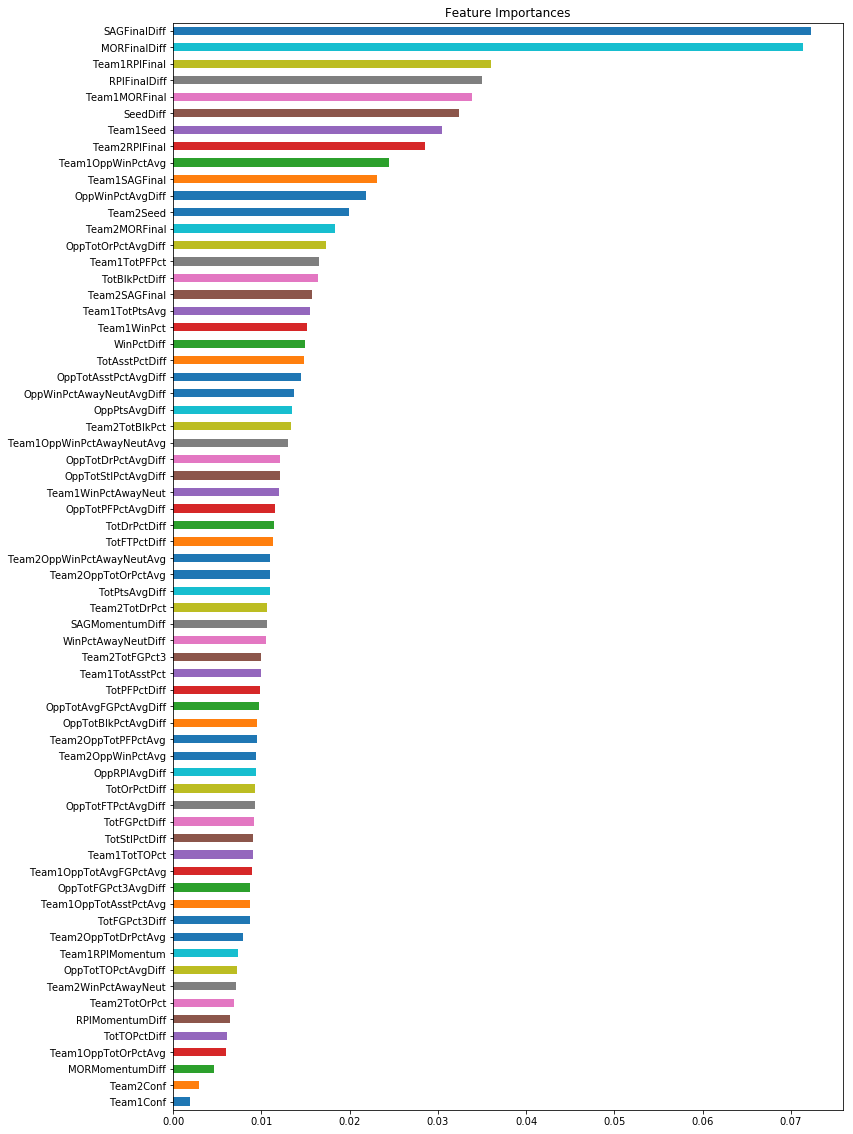

In [311]:
# Basic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_leaf=5, n_estimators=30)
modelfit(rf, X, y)

In [313]:
y_pred_binary = rf.predict(X_val)
y_pred_proba = rf.predict_proba(X_val)[:,1]

# y_pred_proba = np.clip(y_pred_proba, 0.15, 0.85)

print ("Accuracy : %.4g" % metrics.accuracy_score(y_val, y_pred_binary))
print ("Log_Loss : %.4g" % metrics.log_loss(y_val, y_pred_proba))

Accuracy : 0.791
Log_Loss : 0.4977


### lightGBM Classifier

C:\Users\Robert McKee\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9847
Model's Log_Loss Score : 0.2054
CV Log_Loss Score : Mean - -0.583 | Std - 0.05032 | Min - -0.6563 | Max - -0.5348


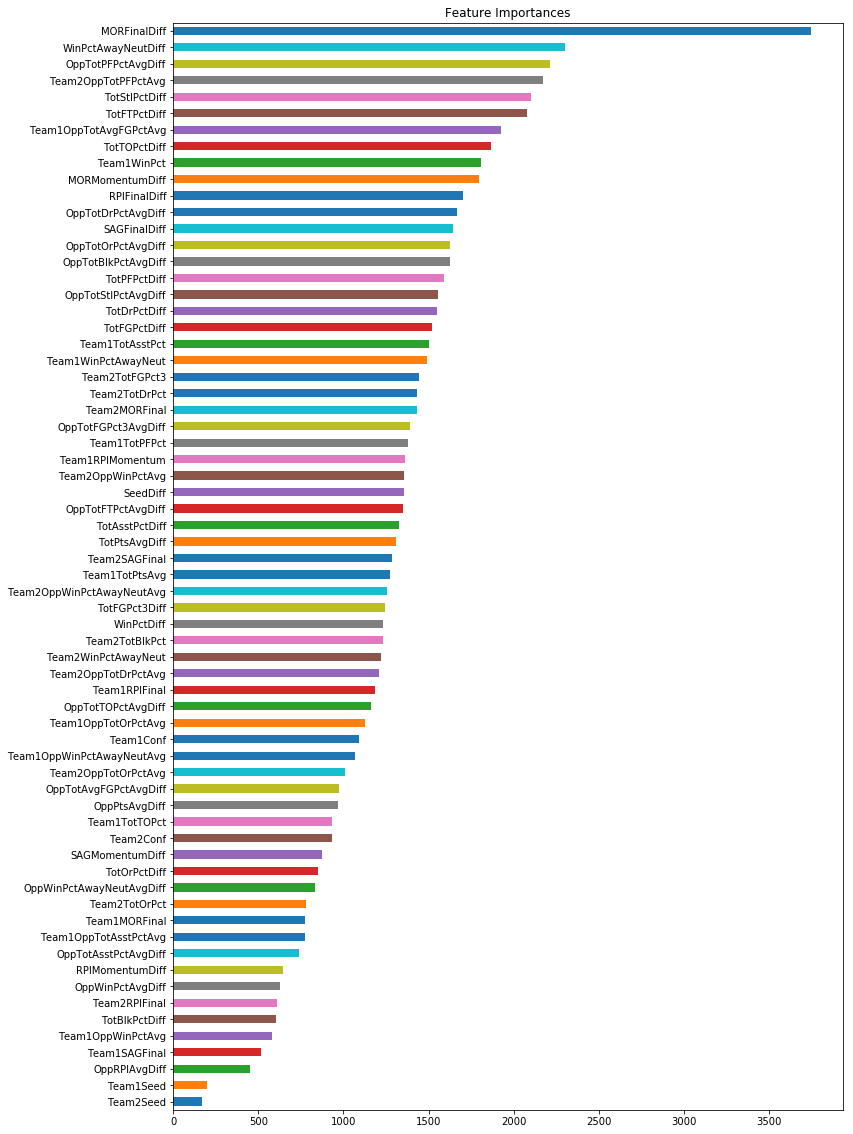

In [300]:
import lightgbm as lgb
gbm0 = lgb.LGBMClassifier(
    metric='log_loss',
    learning_rate=0.001,
    n_estimators=3500, 
 )
modelfit(gbm0, X, y)

In [301]:
y_pred_binary = gbm0.predict(X_val)
y_pred_proba = gbm0.predict_proba(X_val)[:,1]
print ("Accuracy : %.4g" % metrics.accuracy_score(y_val, y_pred_binary))
print ("Log_Loss : %.4g" % metrics.log_loss(y_val, y_pred_proba))

Accuracy : 0.7313
Log_Loss : 0.5335


C:\Users\Robert McKee\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### KNN Classifier

In [257]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
modelfit(neigh, Xs, ys, printFeatureImportance=False)  


Model Report
Accuracy : 0.8184
Model's Log_Loss Score : 0.3765
CV Log_Loss Score : Mean - -4.028 | Std - 0.972 | Min - -5.15 | Max - -2.519


In [258]:
# Evaluate model on validation dataset
y_pred_binary = neigh.predict(Xs_val)
y_pred_proba = neigh.predict_proba(Xs_val)[:,1]
print ("Accuracy : %.4g" % metrics.accuracy_score(ys_val, y_pred_binary))
print ("Log_Loss : %.4g" % metrics.log_loss(ys_val, y_pred_proba))

Accuracy : 0.6567
Log_Loss : 4.996


### Logistic Regression

In [229]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

# Find th best C parameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=linear_model.LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
clf.fit(Xs, ys)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: 0.7133, with best C: 0.01


In [230]:
logreg = linear_model.LogisticRegression(C=0.01)
modelfit(logreg, Xs, ys, printFeatureImportance=False)


Model Report
Accuracy : 0.7276
Model's Log_Loss Score : 0.5238
CV Log_Loss Score : Mean - -0.5485 | Std - 0.03459 | Min - -0.609 | Max - -0.5145


In [231]:
y_pred_binary = logreg.predict(Xs_val)
y_pred_proba = logreg.predict_proba(Xs_val)[:,1]
print ("Accuracy : %.4g" % metrics.accuracy_score(ys_val, y_pred_binary))
print ("Log_Loss : %.4g" % metrics.log_loss(ys_val, y_pred_proba))

Accuracy : 0.7164
Log_Loss : 0.4842


In [232]:
# import pickle

# # save the model to disk
# filename = 'my_model_lr_0313v2.sav'
# pickle.dump(logreg, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# clf2.predict(X[0:1])
# result = loaded_model.score(X_test, Y_test)
# print(result)

### Neural Network 

In [233]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers

from keras.regularizers import l2, l1
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [235]:
Xs.shape

(914, 78)

In [236]:
seed = 7
BATCH_SIZE = 40  # 32 is the default
EPOCHS = 7 
numpy.random.seed(seed)


model = Sequential()
model.add(Dense(10, input_dim=Xs.shape[1],
                activation='relu'))  # , kernel_regularizer=l2(l2_lambda
model.add(Dense(48, activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

history = model.fit(
    Xs, ys, epochs=EPOCHS,
    batch_size=BATCH_SIZE)  # callbacks go here; callbacks=callbacks_list
score = model.evaluate(Xs_val, ys_val, batch_size=BATCH_SIZE)
print("Log_loss, accuracy on validation data:", score)

Epoch 1/7
914/914 [==============================] - 16s 18ms/step - loss: 0.6583 - acc: 0.5908
Epoch 2/7
914/914 [==============================] - 0s 37us/step - loss: 0.5788 - acc: 0.6958
Epoch 3/7
914/914 [==============================] - 0s 37us/step - loss: 0.5429 - acc: 0.7123
Epoch 4/7
914/914 [==============================] - 0s 36us/step - loss: 0.5302 - acc: 0.7330
Epoch 5/7
914/914 [==============================] - 0s 34us/step - loss: 0.5200 - acc: 0.7429
Epoch 6/7
914/914 [==============================] - 0s 39us/step - loss: 0.5154 - acc: 0.7363
Epoch 7/7
67/67 [==============================] - 0s 434us/step
Log_loss, accuracy on validation data: [0.4813425718848385, 0.7313432835820896]


In [237]:
# [0.47691613346783085, 0.7313432835820896]
# Best = -3,3 minmax on pred_diff + pred_dummies + pred_tier1 + tier 2; batch 40; 10 x(5x48) x 16; 7 epochs

# model.save('my_model_nn_0313v1.h5')
# from keras.models import load_model
# model=load_model('my_model_nn_0011v1.h5')

In [239]:
proba = model.predict_proba(Xs_val)
proba[:10]

array([[0.25411972],
       [0.6177053 ],
       [0.23826139],
       [0.1982458 ],
       [0.94223624],
       [0.807907  ],
       [0.03072421],
       [0.01452897],
       [0.98184514],
       [0.74786675]], dtype=float32)

## Stacking

In [315]:
# Train > validation > test; test is the holdout

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import load_model

In [316]:
# Load datasets, unscaled and scaled 
X_test_meta, y_test_meta = X_val, y_val  # In this model, we have 3 layers of data, not 2; so, first, reassign the validaton data to test
X_meta, X_val_meta, y_meta, y_val_meta = train_test_split(
    X, y, test_size=0.4)  # Then split the train data into train and validation

Xs_test_meta, ys_test_meta = Xs_val, ys_val  # In this model, we have 3 layers of data, not 2; so, first, reassign the validaton data to test
Xs_meta, Xs_val_meta, ys_meta, ys_val_meta = train_test_split(
    Xs, ys,
    test_size=0.4)  # Then split the train data into train and validation

In [318]:
# Specify models --use tuned parameters from above
model0= lgb.LGBMClassifier(
    metric='log_loss',
    learning_rate=0.001,
    n_estimators=1000
)
model1 = RandomForestClassifier(min_samples_leaf=5, n_estimators=30)
model2 = linear_model.LogisticRegression(C=0.01)
model3 = Sequential()
model3.add(Dense(10, input_dim=Xs.shape[1],
                 activation='relu'))  # , kernel_regularizer=l2(l2_lambda
model3.add(Dense(48, activation='relu'))
model3.add(Dense(48, activation='relu'))
model3.add(Dense(48, activation='relu'))
model3.add(Dense(48, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(
    loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# Fit the data -
model0.fit(X_meta,y_meta)
model1.fit(X_meta, y_meta)
model2.fit(Xs_meta, ys_meta)
model3.fit(Xs_meta, ys_meta, epochs=7, batch_size=40)
print("Models fitted...")
print()


# Make predictions on the validation data
y_pred_binary = model0.predict(X_val_meta)
preds0 = model0.predict_proba(X_val_meta)
y_pred_proba = model0.predict_proba(X_val_meta)[:, 1]
print("Model 0 LGBM Accuracy : %.4g" % metrics.accuracy_score(y_val_meta, y_pred_binary))
print("Model 0 LGBM Log_Loss : %.4g" % metrics.log_loss(y_val_meta, y_pred_proba))
print()

y_pred_binary = model1.predict(X_val_meta)
preds1 = model1.predict_proba(X_val_meta)
y_pred_proba = model1.predict_proba(X_val_meta)[:, 1]
print("Model 1 RF Accuracy : %.4g" % metrics.accuracy_score(y_val_meta, y_pred_binary))
print("Model 1 RF Log_Loss : %.4g" % metrics.log_loss(y_val_meta, y_pred_proba))
print()

y_pred_binary = model2.predict(Xs_val_meta)
preds2 = model2.predict_proba(Xs_val_meta)
y_pred_proba = model2.predict_proba(Xs_val_meta)[:, 1]
print(
    "Model 2 LR Accuracy : %.4g" % metrics.accuracy_score(ys_val_meta, y_pred_binary))
print("Model 2 LR Log_Loss : %.4g" % metrics.log_loss(ys_val_meta, y_pred_proba))
print()

preds3 = model3.predict(Xs_val_meta)
y_pred_binary = preds3.round(
)  # Keras outputs predict as a prbability; so here, convert to 0,1
y_pred_proba = model3.predict(Xs_val_meta)
print(
    "Model 3 NN Accuracy : %.4g" % metrics.accuracy_score(ys_val_meta, y_pred_binary))
print("Model 3 NN Log_Loss : %.4g" % metrics.log_loss(ys_val_meta, y_pred_proba))
print()


# Make predictions on the test (holdout) data
test_preds0 = model0.predict_proba(
    X_test_meta
)  
test_preds1 = model1.predict_proba(
    X_test_meta
)  # Test refers to our valid datasets (2017 data) in the models above
test_preds2 = model2.predict_proba(Xs_test_meta)
test_preds3 = model3.predict(Xs_test_meta)

# Form new datasets for the next round by stacking the predictions
stacked_predictions = np.column_stack((preds0,preds1, preds2, preds3))
stacked_test_predictions = np.column_stack((test_preds0,test_preds1, test_preds2,
                                            test_preds3))

# Specify the meta model
meta_model = LogisticRegression(C=0.8)
# meta_model=RandomForestClassifier(min_samples_leaf=5, n_estimators=40)

# Fit the meta model
meta_model.fit(stacked_predictions, y_val_meta)

# Make final predictions
final_predictions = meta_model.predict(stacked_test_predictions)
y_pred_binary = final_predictions
y_pred_proba = meta_model.predict_proba(stacked_test_predictions)[:, 1]
print("Meta Model Accuracy : %.4g" % metrics.accuracy_score(
    y_test_meta, y_pred_binary))
print("Meta Model Log_Loss : %.4g" % metrics.log_loss(y_test_meta, y_pred_proba))

Epoch 1/7
548/548 [==============================] - 1s 1ms/step - loss: 0.6554 - acc: 0.6077
Epoch 2/7
548/548 [==============================] - 0s 44us/step - loss: 0.5911 - acc: 0.6898
Epoch 3/7
548/548 [==============================] - 0s 40us/step - loss: 0.5632 - acc: 0.7099
Epoch 4/7
548/548 [==============================] - 0s 46us/step - loss: 0.5504 - acc: 0.7153
Epoch 5/7
548/548 [==============================] - 0s 44us/step - loss: 0.5372 - acc: 0.7117
Epoch 6/7
548/548 [==============================] - 0s 44us/step - loss: 0.5305 - acc: 0.7190
Epoch 7/7
548/548 [==============================] - 0s 44us/step - loss: 0.5250 - acc: 0.7172
Models fitted...

Model 0 LGBM Accuracy : 0.7104
Model 0 LGBM Log_Loss : 0.5824

Model 1 RF Accuracy : 0.7158
Model 1 RF Log_Loss : 0.5753

Model 2 LR Accuracy : 0.7268
Model 2 LR Log_Loss : 0.5291



C:\Users\Robert McKee\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model 3 NN Accuracy : 0.7077
Model 3 NN Log_Loss : 0.5421

Meta Model Accuracy : 0.7164
Meta Model Log_Loss : 0.5642


In [398]:
# Compare predictions and probabilities to ground truth 
print(y_pred_binary[:20])

[0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0]


In [425]:
print(y_test[:20])

914    1
915    1
916    0
917    0
918    1
919    1
920    0
921    0
922    1
923    1
924    0
925    1
926    1
927    1
928    1
929    0
930    0
931    0
932    0
933    0
Name: Result, dtype: int64


In [400]:
print(y_pred_proba[:20])

[0.41783361 0.58072109 0.46607685 0.42484927 0.76450723 0.69287601
 0.17842794 0.17364152 0.73718447 0.57745635 0.59962649 0.4634206
 0.68024749 0.67913245 0.67923977 0.17167612 0.31712963 0.19684251
 0.28343174 0.4336666 ]


## 2018 Tournament Predictions

In [246]:
# Load the sample submission file provided by contest 
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmissionStage2 (1).csv')

In [247]:
df_sample_sub.head()

,ID,Pred
0,2018_1104_1112,0.5
1,2018_1104_1113,0.5
2,2018_1104_1116,0.5
3,2018_1104_1120,0.5
4,2018_1104_1137,0.5


In [248]:
# Split the ID into components
df_sample_sub["Season"], df_sample_sub["Team1ID"], df_sample_sub[
    "Team2ID"] = df_sample_sub['ID'].str.split('_', 2).str

In [249]:
df_sample_sub.dtypes

ID          object
Pred       float64
Season      object
Team1ID     object
Team2ID     object
dtype: object

In [251]:
# Convert objects to numerics 
df_sample_sub[['Season', 'Team1ID', 'Team2ID']]=df_sample_sub[['Season', 'Team1ID', 'Team2ID']].apply(pd.to_numeric)

In [252]:
# Join team names to IDs for context 
df_teams = pd.read_csv(data_dir + 'Teams.csv')
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [253]:
df_teams.drop(columns=['FirstD1Season', 'LastD1Season'], inplace=True)
df_teams.rename(columns={'TeamID': 'Team1ID'}, inplace=True)
df_teams.head()

,Team1ID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [254]:
df_sample_sub=df_sample_sub.merge(df_teams, how='left', on='Team1ID')
df_sample_sub.rename(columns={'TeamName': 'Team1Name'}, inplace=True)
df_sample_sub.head()

,ID,Pred,Season,Team1ID,Team2ID,Team1Name
0,2018_1104_1112,0.5,2018,1104,1112,Alabama
1,2018_1104_1113,0.5,2018,1104,1113,Alabama
2,2018_1104_1116,0.5,2018,1104,1116,Alabama
3,2018_1104_1120,0.5,2018,1104,1120,Alabama
4,2018_1104_1137,0.5,2018,1104,1137,Alabama


In [255]:
df_teams.rename(columns={'Team1ID': 'Team2ID'}, inplace=True)
df_sample_sub=df_sample_sub.merge(df_teams, how='left', on='Team2ID')
df_sample_sub.rename(columns={'TeamName': 'Team2Name'}, inplace=True)
df_sample_sub.head()

,ID,Pred,Season,Team1ID,Team2ID,Team1Name,Team2Name
0,2018_1104_1112,0.5,2018,1104,1112,Alabama,Arizona
1,2018_1104_1113,0.5,2018,1104,1113,Alabama,Arizona St
2,2018_1104_1116,0.5,2018,1104,1116,Alabama,Arkansas
3,2018_1104_1120,0.5,2018,1104,1120,Alabama,Auburn
4,2018_1104_1137,0.5,2018,1104,1137,Alabama,Bucknell


Append master data to Team1ID and Team2ID and run predictions; append those predictions to the submission file, and then delete all but the required columns (ID(for the game) and Pred)

In [241]:
# Get the scaled 2018 dataset 
Xs = df_tour_2018_scaled[predictors_dummies + predictors_diff +
                              predictors_tier1_adds + predictors_tier2_adds].values.astype('float32')
ys = df_tour_2018_scaled.Result.values

In [242]:
# Predict 2018 tournament using Logistic Regression model 
lr_pred_proba=logreg.predict_proba(Xs)[:,1]
df_tour_2018_scaled['LRPredictions']=lr_pred_proba

In [243]:
# Predict 2018 tournament using Neural Network model 
nn_pred_proba=model.predict_proba(Xs)
df_tour_2018_scaled['NNPredictions']=nn_pred_proba

In [245]:
# Remove unnecessary columns 
predictions_2018=df_tour_2018_scaled[['Team1ID', 'Team2ID', 'LRPredictions', 'NNPredictions']]

In [258]:
# Merge predictions on to sample submission file 
final_submission=df_sample_sub.merge(predictions_2018, how='left', on=['Team1ID', 'Team2ID'])

In [260]:
final_submission.head(20)

,ID,Pred,Season,Team1ID,Team2ID,Team1Name,Team2Name,LRPredictions,NNPredictions
0,2018_1104_1112,0.5,2018,1104,1112,Alabama,Arizona,0.267451,0.305078
1,2018_1104_1113,0.5,2018,1104,1113,Alabama,Arizona St,0.452400,0.427335
2,2018_1104_1116,0.5,2018,1104,1116,Alabama,Arkansas,0.323942,0.219953
3,2018_1104_1120,0.5,2018,1104,1120,Alabama,Auburn,0.259781,0.257463
4,2018_1104_1137,0.5,2018,1104,1137,Alabama,Bucknell,0.566207,0.402630
5,2018_1104_1138,0.5,2018,1104,1138,Alabama,Buffalo,0.416630,0.485345
6,2018_1104_1139,0.5,2018,1104,1139,Alabama,Butler,0.357679,0.401000
7,2018_1104_1153,0.5,2018,1104,1153,Alabama,Cincinnati,0.179941,0.155520
8,2018_1104_1155,0.5,2018,1104,1155,Alabama,Clemson,0.260516,0.248314
9,2018_1104_1158,0.5,2018,1104,1158,Alabama,Col Charleston,0.591820,0.508387


In [261]:
# Save final predictions with team names for future reference 
# final_submission.to_csv('NCAA_2018_final_predictions.csv', index=False)
# final_submission=pd.read_csv('NCAA_2018_final_predictions.csv')

In [264]:
# Remove extraneous columns and align with sample submission requirements 
lr_submission=final_submission[['ID', 'LRPredictions']]
nn_submission=final_submission[['ID', 'NNPredictions']]
lr_submission.rename(columns={'LRPredictions': 'Pred'}, inplace=True)
nn_submission.rename(columns={'NNPredictions': 'Pred'}, inplace=True)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [265]:
lr_submission.to_csv('Final_Submission_031318_LR', index=False)
nn_submission.to_csv('Final_Submission_031318_NN', index=False)